# Linear Regression

In [1]:
import sys
from pathlib import Path

# Adjust the path based on the location of your notebook
sys.path.append(str(Path().resolve().parent))

# Second cell: Import the PATH from settings
from linear_regression.settings import PATH

print(PATH)


C:\Dev\Statistical Learning


## Introduction

Developing a regression model can be done with either Statsmodels or Sklearn. We will use a combination of both due to the ease of fitting the model with Statsmodels and handling the data with Sklearn.

Before building a regression model, you need to ensure the following:
- The data is in the correct format to train the model, i.e., there is no missing values and outliers. 
- Categorical (ordinal and non-ordinal) variables are handled correctly. This can be done in using Encoders (One-hot or Ordinal) from Sklearn or pandas get_dummies.
- The independent variables can also be scaled to the same unit (StandardScaler or MinMaxScaler using Sklearn). 

In [2]:
# Importing packages to develop the model
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor as VIF
from scipy import stats
# import sklearn.preprocessing as preprocessing
from sklearn.preprocessing import (OneHotEncoder, OrdinalEncoder, StandardScaler)

from regression_diagnostics import LinearRegDiagnostic

## Assumptions of Linear Regression

1. **Linearity**: The relationship between the independent variables (predictors) and the dependent variable (outcome) is linear. This means the model is correctly specified as a linear combination of the predictors.

2. **Independence**: The observations are independent of each other. This means that the value of the residual for one observation is not related to the value of the residual for another observation.

3. **Homoscedasticity**: The residuals (errors) have constant variance at every level of the independent variable(s). This means that the spread of the residuals should be roughly the same across all levels of the predictors.

4. **No Multicollinearity**: The independent variables are not perfectly collinear, which means there is no exact linear relationship among the predictors. High multicollinearity can make it difficult to determine the individual effect of each predictor.

5. **Normality of Residuals**: The residuals of the model are normally distributed. This assumption is particularly important for small sample sizes and for making inferences about the coefficients (confidence intervals and hypothesis tests).

6. **No Autocorrelation**: The residuals are not correlated with each other, which is particularly relevant for time series data. If the residuals are correlated, it violates the assumption of independence.

These assumptions are critical for the proper application and interpretation of linear models. Violations of these assumptions can lead to biased estimates, incorrect inferences, and poor predictive performance.

### Caveats

- Non-linearity of independent variables can create issues in predictions and residuals -> use transformations (log, etc) on independent variable -> check residual plots for linearity.
- Correlation in residuals can create issues such as underestimation of standard errors which creates low confidence bounds around coefficients and therefore artificially low p-values -> check residual plots.
- Heteroscedasticity is when there are non-constant variance in the residuals and residual plots has a funnel shape -> transformation of independent variable can fix this -> check residual plots. 
- Assess outliers and leverage points -> residual plots. Leverage points you can check with leverage statistic and Cook's distance (measures influential points - observation is dropped and model effect is again tested to analyse influence).
- Collinearity of independent variables creates issues -> check Variance Inflation Factor (VIF). 
- Autocorrelation can be directly tested with Durbin-Wattson statistic. 

## Example: Handling categorical data (Sklearn)

We will use the Boston housing data set, which is obtained from the Introduction to Statistical Learning textbook. We will attempt to predict Sales (child car seat sales) in 400 locations based on a number of predictors.

In [3]:
dir_data = PATH / Path('data')
input_file = 'Carseats.csv'
file_path_data = dir_data / Path(input_file)

df = pd.read_csv(file_path_data)
df

,Sales,CompPrice,Income,Advertising,Population,Price,ShelveLoc,Age,Education,Urban,US
0,9.50,138,73,11,276,120,Bad,42,17,Yes,Yes
1,11.22,111,48,16,260,83,Good,65,10,Yes,Yes
2,10.06,113,35,10,269,80,Medium,59,12,Yes,Yes
3,7.40,117,100,4,466,97,Medium,55,14,Yes,Yes
4,4.15,141,64,3,340,128,Bad,38,13,Yes,No
...,...,...,...,...,...,...,...,...,...,...,...
395,12.57,138,108,17,203,128,Good,33,14,Yes,Yes
396,6.14,139,23,3,37,120,Medium,55,11,No,Yes
397,7.41,162,26,12,368,159,Medium,40,18,Yes,Yes
398,5.94,100,79,7,284,95,Bad,50,12,Yes,Yes


In [4]:
df.dtypes

Sales          float64
CompPrice        int64
Income           int64
Advertising      int64
Population       int64
Price            int64
ShelveLoc       object
Age              int64
Education        int64
Urban           object
US              object
dtype: object

Lets assume we only want to use 'Price', 'Urban', 'US' to predict Sales. We can demonstrate here how to handle categorical variables in a dataset mixed with numerical and categorical values. 

In [4]:
columns = ['Sales', 'Price', 'Urban', 'US']
df = df[columns]
df

,Sales,Price,Urban,US
0,9.50,120,Yes,Yes
1,11.22,83,Yes,Yes
2,10.06,80,Yes,Yes
3,7.40,97,Yes,Yes
4,4.15,128,Yes,No
...,...,...,...,...
395,12.57,128,Yes,Yes
396,6.14,120,No,Yes
397,7.41,159,Yes,Yes
398,5.94,95,Yes,Yes


One-hot encoding of the categorical features. Their columns sum to one, so to avoid collinearity with an intercept, the first column is dropped. This can be done by encoding the categorical variables into numbers. There are two main ways to do so using Sklearn,
which are Ordinal Encoding and One-Hot Encoding or pandas get_dummies. 

When a categorical attribute has hundreds or thousands of categories, one-hot encoding it results in a very large matrix full of 0s except for a single 1 per row. In this case, a sparse matrix is exactly what you need:
it will save plenty of memory and speed up computations (automatically done by Sklearn). You can use a sparse matrix mostly like a normal 2D array,⁠ but if you want to convert it to a (dense) NumPy array, just call the toarray() method.

In [6]:
# Extract categorical columns from the dataframe, here we extract the columns with object datatype as they are the categorical columns
categorical_columns = df.select_dtypes(include=['object']).columns.tolist()

# Initialize OneHotEncoder, drop first reduces collinearity
encoder = OneHotEncoder(drop='first')

# Apply one-hot encoding to the categorical columns (fit_transform)
one_hot_encoded = encoder.fit_transform(df[categorical_columns]).toarray()

# Create a DataFrame with the one-hot encoded columns, we use get_feature_names_out() to get the column names for the encoded data
one_hot_df = pd.DataFrame(one_hot_encoded, columns=encoder.get_feature_names_out(categorical_columns))

# Concatenate the one-hot encoded dataframe with the original dataframe, axis=1 is concatenating on the column
df_encoded = pd.concat([df, one_hot_df], axis=1)

# Drop the original categorical columns
df_encoded = df_encoded.drop(categorical_columns, axis=1)
df_encoded

,Sales,Price,Urban_Yes,US_Yes
0,9.50,120,1.0,1.0
1,11.22,83,1.0,1.0
2,10.06,80,1.0,1.0
3,7.40,97,1.0,1.0
4,4.15,128,1.0,0.0
...,...,...,...,...
395,12.57,128,1.0,1.0
396,6.14,120,0.0,1.0
397,7.41,159,1.0,1.0
398,5.94,95,1.0,1.0


In [7]:
encoder.categories_

[array(['No', 'Yes'], dtype=object), array(['No', 'Yes'], dtype=object)]

## Example: Explaining the Statsmodels Regression Output (OLS)

In Statsmodels we need to add a constant to the dataframe when we fit the model, for Sklearn this is not needed. 

There are two ways to fit a Linear regression model in Statsmodels. Either directly as Ordinary Least Squares model or as a Generalized Linear Model.

- sm.OLS(y, X)
- sm.GLM(y, X, family=sm.families.Gaussian())

In [8]:
df_encoded = sm.add_constant(df_encoded)
X = df_encoded.drop(columns='Sales')
y = df_encoded['Sales']
model_1 = sm.OLS(y, X)
results_1 = model_1.fit()
results_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Sales   R-squared:                       0.239
Model:                            OLS   Adj. R-squared:                  0.234
Method:                 Least Squares   F-statistic:                     41.52
Date:                Sat, 18 May 2024   Prob (F-statistic):           2.39e-23
Time:                        20:13:51   Log-Likelihood:                -927.66
No. Observations:                 400   AIC:                             1863.
Df Residuals:                     396   BIC:                             1879.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         13.0435      0.651     20.036      0.000      11.764      14.323
Price         -0.0545      0.005    -10.389      0.000      -0.065      -0.044
Urban_Yes     -0.0219      0.272     -0.081      0.936      -0.556       0.512
US_Yes         1.2006      0.259      4.635      0.000       0.691       1.710
==============================================================================
Omnibus:                        0.676   Durbin-Watson:                   1.912
Prob(Omnibus):                  0.713   Jarque-Bera (JB):                0.758
Skew:                           0.093   Prob(JB):                        0.684
Kurtosis:                       2.897   Cond. No.                         628.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Sales decrease with increase in Price. For each unit increase in Price, Sales decrease by 0.0545 * 1000 = 54.5 dollars on average. There seems to be a statistically significant relationship between Sales and whether the store is in the U.S. or not. We expect carseats sold in the US to achieve a sale price 1,200 dollars higher on average. There does not seem to be significant relationship between Sales and whether the store is in an urban or rural relationship.

y=13.0435+(−0.0219×Urban)+(1.2006×US)+(−0.0545×Price)

In [9]:
# Residual Standard Error (RMSE)
np.sqrt(results_1.mse_resid)

2.4724924402701642

beta_0 = SSR/mean
beta_1 = y_mean - beta 

y = X(X'X)^-1Xbeta^hat

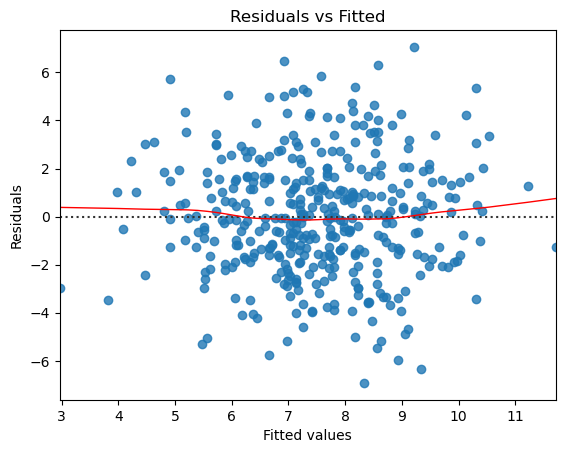

In [10]:
# Fitted values
model1_fitted_y = results_1.fittedvalues

# Normalized residuals
model1_norm_residuals = results_1.get_influence().resid_studentized

# Absolute squared normalized residuals
model1_norm_residuals_abs_sqrt = np.sqrt(np.abs(model1_norm_residuals))

# Leverage, from statsmodels internals
model1_leverage = results_1.get_influence().hat_matrix_diag

# Plot 1: residuals vs. fitted values
plot1 = plt.figure(1)
sns.residplot(x=model1_fitted_y, y=df['Sales'], lowess=True, line_kws={'color': 'red', 'lw': 1})
plt.title('Residuals vs Fitted')
plt.xlabel('Fitted values')
plt.ylabel('Residuals')
plt.show()

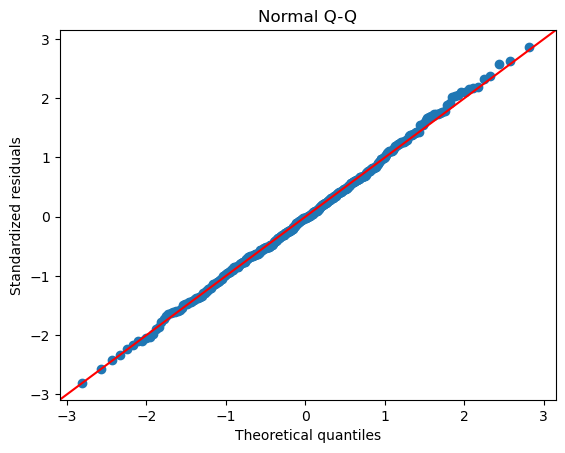

In [11]:
# plot 2: normal Q-Q
plot2 = sm.qqplot(model1_norm_residuals, fit=True, line='45')
plot2.axes[0].set_title('Normal Q-Q')
plot2.axes[0].set_xlabel('Theoretical quantiles')
plot2.axes[0].set_ylabel('Standardized residuals')
plt.show()

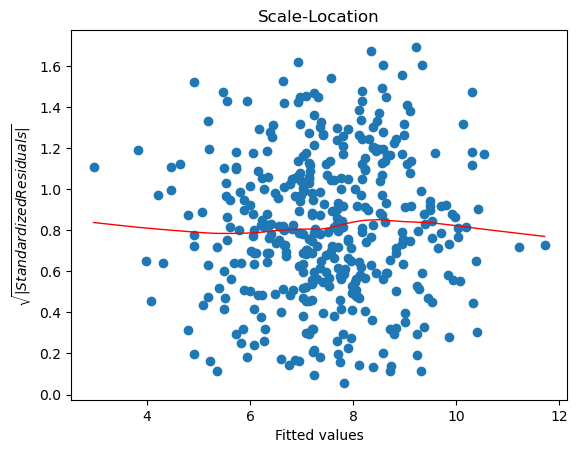

In [12]:
# Fitted values
model1_fitted_y = results_1.fittedvalues

# Normalized residuals
model1_norm_residuals = results_1.get_influence().resid_studentized_internal

# Absolute squared normalized residuals
model1_norm_residuals_abs_sqrt = np.sqrt(np.abs(model1_norm_residuals))

# Leverage, from statsmodels internals
model1_leverage = results_1.get_influence().hat_matrix_diag

# Plot 3: scale-location
plot3 = plt.figure(3)
plt.scatter(model1_fitted_y, model1_norm_residuals_abs_sqrt)
sns.regplot(x=model1_fitted_y, y=model1_norm_residuals_abs_sqrt, scatter=False, ci=False, lowess=True, line_kws={'color': 'red', 'lw': 1})
plt.title('Scale-Location')
plt.xlabel('Fitted values')
plt.ylabel('$\sqrt{|Standardized Residuals|}$')
plt.show()

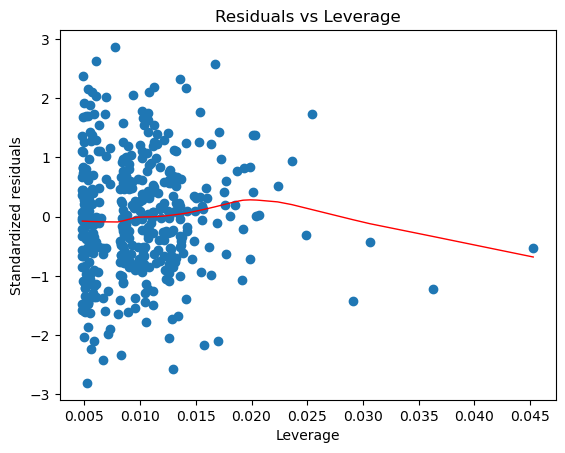

In [13]:
# Fitted values
model1_fitted_y = results_1.fittedvalues

# Normalized residuals
model1_norm_residuals = results_1.get_influence().resid_studentized_internal

# Absolute squared normalized residuals
model1_norm_residuals_abs_sqrt = np.sqrt(np.abs(model1_norm_residuals))

# Leverage, from statsmodels internals
model1_leverage = results_1.get_influence().hat_matrix_diag

# Plot 4: residuals vs. leverage
plot4 = plt.figure(4)
plt.scatter(model1_leverage, model1_norm_residuals)
sns.regplot(x=model1_leverage, y=model1_norm_residuals, scatter=False, ci=False, lowess=True, line_kws={'color': 'red', 'lw': 1})
plt.title('Residuals vs Leverage')
plt.xlabel('Leverage')
plt.ylabel('Standardized residuals')
plt.show()

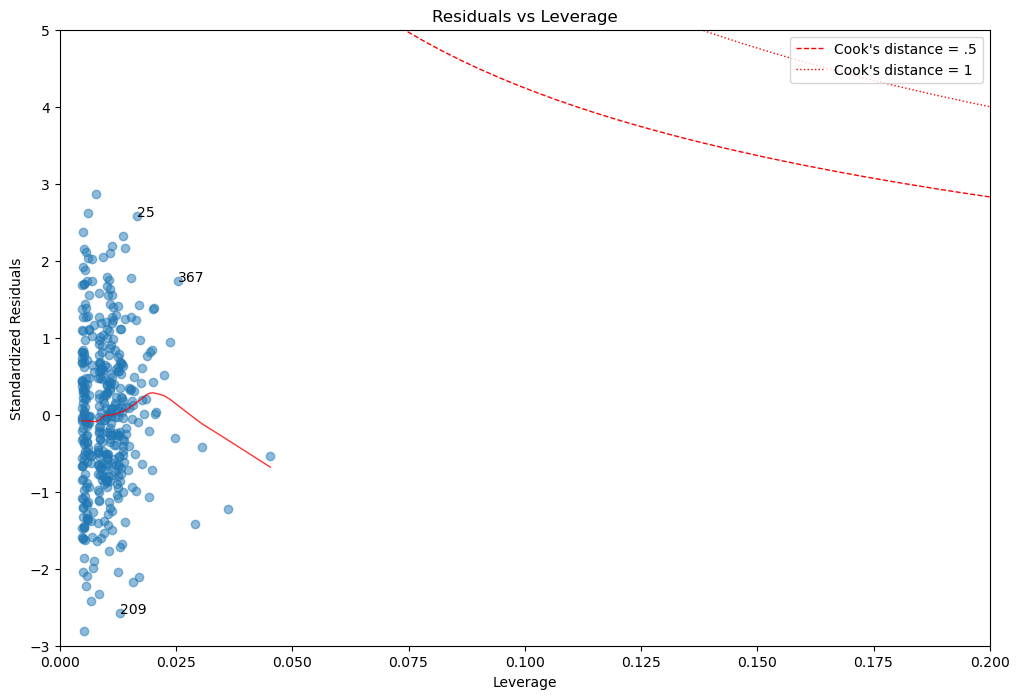

In [14]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming results and df are already defined

# Fitted values
model1_fitted_y = results_1.fittedvalues

# Normalized residuals
model1_norm_residuals = results_1.get_influence().resid_studentized_internal

# Absolute squared normalized residuals
model1_norm_residuals_abs_sqrt = np.sqrt(np.abs(model1_norm_residuals))

# Leverage, from statsmodels internals
model1_leverage = results_1.get_influence().hat_matrix_diag

# Cook's distance
model_cooks = results_1.get_influence().cooks_distance[0]

# Plot 4: residuals vs. leverage with Cook's distance
plot_lm_4 = plt.figure(4)
plot_lm_4.set_figheight(8)
plot_lm_4.set_figwidth(12)

plt.scatter(model1_leverage, model1_norm_residuals, alpha=0.5)
sns.regplot(x=model1_leverage, y=model1_norm_residuals, 
            scatter=False, 
            ci=False, 
            lowess=True,
            line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8})

plt.xlim(0, 0.20)
plt.ylim(-3, 5)
plt.title('Residuals vs Leverage')
plt.xlabel('Leverage')
plt.ylabel('Standardized Residuals')

# Annotations
leverage_top_3 = np.flip(np.argsort(model_cooks), 0)[:3]

for i in leverage_top_3:
    plt.annotate(i, 
                 xy=(model1_leverage[i], model1_norm_residuals[i]))

# Shenanigans for Cook's distance contours
def graph(formula, x_range, label=None, ls='-'):
    x = x_range
    y = formula(x)
    plt.plot(x, y, label=label, lw=1, ls=ls, color='red')

p = len(results_1.params) # number of model parameters

graph(lambda x: np.sqrt((0.5 * p * (1 - x)) / x), 
      np.linspace(0.001, 0.200, 50), 
      'Cook\'s distance = .5', ls='--') # 0.5 line

graph(lambda x: np.sqrt((1 * p * (1 - x)) / x), 
      np.linspace(0.001, 0.200, 50), 'Cook\'s distance = 1', ls=':') # 1 line

plt.legend(loc='upper right')
plt.show()


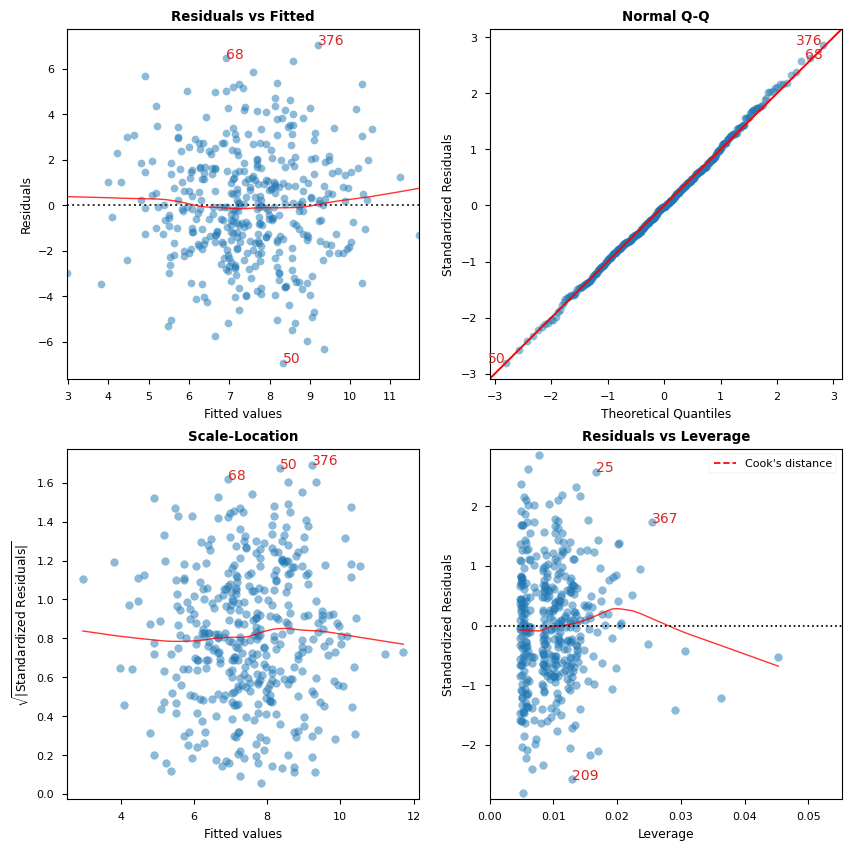

,Features,VIF Factor
2,Urban_Yes,1.00
1,Price,1.01
3,US_Yes,1.01
0,const,27.73


In [15]:
cls = LinearRegDiagnostic(results_1)
vif, fig, ax = cls()
vif

In [16]:
vals = [VIF(X, i) for i in range(1, X.shape[1])]
vif = pd.DataFrame({'vif':vals}, index=X.columns[1:])
vif

,vif
Price,1.005342
Urban_Yes,1.004203
US_Yes,1.005349


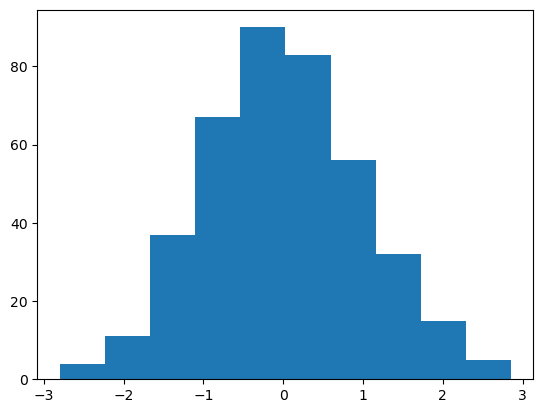

In [17]:
plt.hist(results_1.resid_pearson)
plt.show()

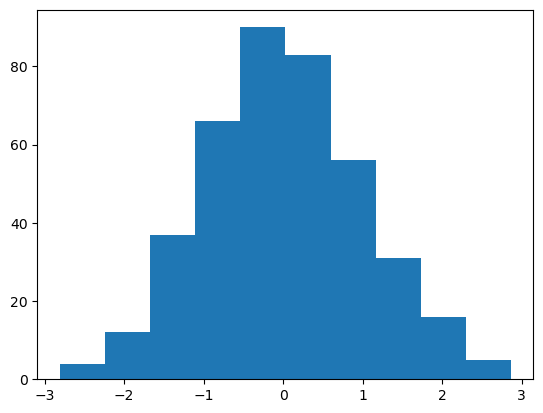

In [18]:
# Normalized residuals
model1_norm_residuals = results_1.get_influence().resid_studentized_internal
plt.hist(model1_norm_residuals)
plt.show()

## Example: Explaining the Statsmodels Regression Output (GLM)

In [19]:
model_2 = sm.GLM(y, X, family=sm.families.Gaussian())
results_2 = model_2.fit()
print(results_2.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                  Sales   No. Observations:                  400
Model:                            GLM   Df Residuals:                      396
Model Family:                Gaussian   Df Model:                            3
Link Function:               Identity   Scale:                          6.1132
Method:                          IRLS   Log-Likelihood:                -927.66
Date:                Sat, 18 May 2024   Deviance:                       2420.8
Time:                        20:14:12   Pearson chi2:                 2.42e+03
No. Iterations:                     3   Pseudo R-squ. (CS):             0.2676
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         13.0435      0.651     20.036      0.0

In [20]:
print(results_2.aic)
print(results_2.deviance)
print(results_2.pearson_chi2)

1863.3120738106177
2420.834671408473
2420.834671408473


In [33]:
predictions = results_2.predict(X)
df_results = pd.DataFrame({'Actual': y, 'Predicted': predictions})
df_results['Residuals'] = abs(df_results['Actual']) - abs(df_results['Predicted'])

In [34]:
df_results['Residuals']

0      1.812936
1      1.517959
2      0.194582
3     -1.539617
4     -1.900820
         ...   
395    5.318607
396   -1.568980
397    1.846832
398   -3.108535
399    2.022936
Name: Residuals, Length: 400, dtype: float64

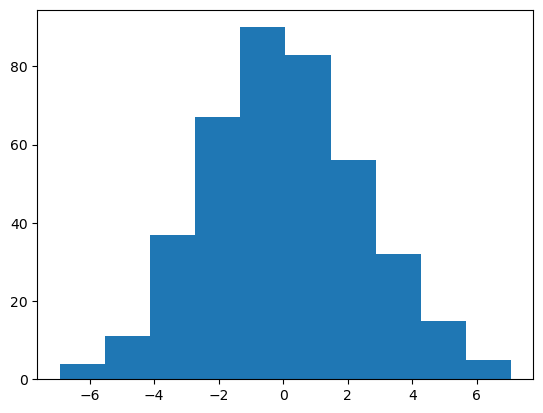

In [35]:
plt.hist(df_results['Residuals'])
plt.show()

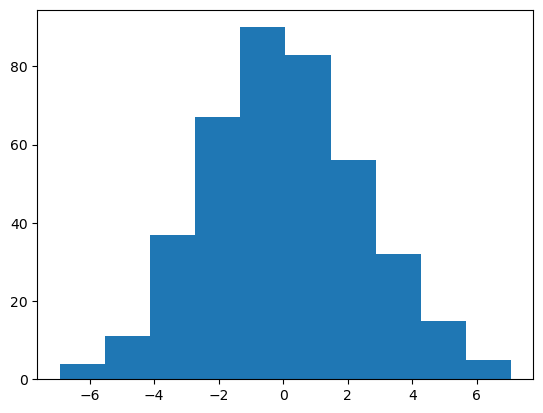

In [30]:
plt.hist(results_2.resid_pearson)
plt.show()

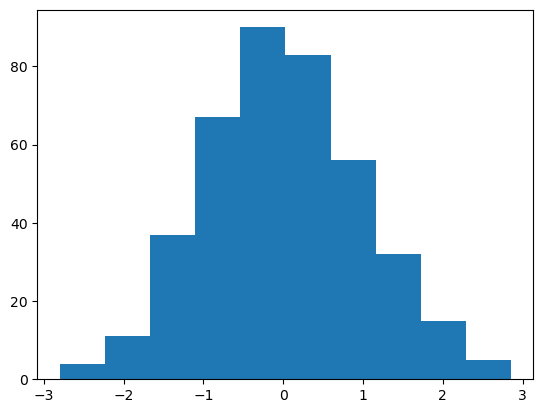

In [31]:
plt.hist(results_2.resid_anscombe)
plt.show()

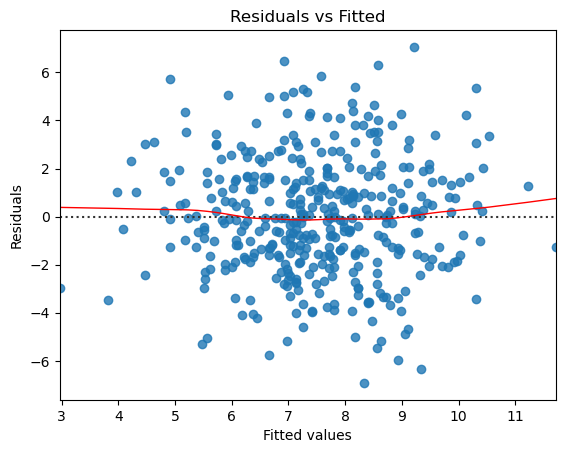

In [40]:
# Fitted values
model2_fitted_y = results_2.fittedvalues

# Normalized residuals
model2_norm_residuals = results_2.get_influence().resid_studentized

# Absolute squared normalized residuals
model2_norm_residuals_abs_sqrt = np.sqrt(np.abs(model2_norm_residuals))

# Leverage, from statsmodels internals
model2_leverage = results_2.get_influence().hat_matrix_diag

# Plot 1: residuals vs. fitted values
plot1 = plt.figure(1)
sns.residplot(x=model2_fitted_y, y=df['Sales'], lowess=True, line_kws={'color': 'red', 'lw': 1})
plt.title('Residuals vs Fitted')
plt.xlabel('Fitted values')
plt.ylabel('Residuals')
plt.show()

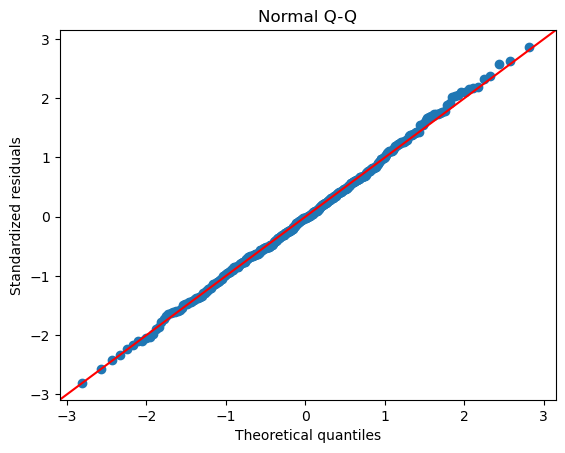

In [41]:
# plot 2: normal Q-Q
plot2 = sm.qqplot(model2_norm_residuals, fit=True, line='45')
plot2.axes[0].set_title('Normal Q-Q')
plot2.axes[0].set_xlabel('Theoretical quantiles')
plot2.axes[0].set_ylabel('Standardized residuals')
plt.show()

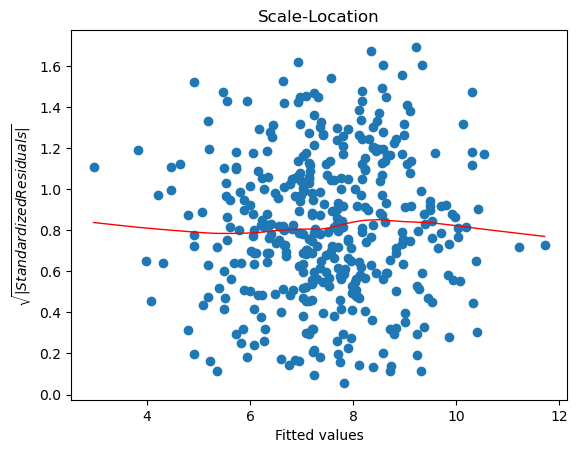

In [42]:
# Fitted values
model2_fitted_y = results_2.fittedvalues

# Normalized residuals
model2_norm_residuals = results_2.get_influence().resid_studentized

# Absolute squared normalized residuals
model2_norm_residuals_abs_sqrt = np.sqrt(np.abs(model2_norm_residuals))

# Leverage, from statsmodels internals
model2_leverage = results_2.get_influence().hat_matrix_diag

# Plot 3: scale-location
plot3 = plt.figure(3)
plt.scatter(model2_fitted_y, model2_norm_residuals_abs_sqrt)
sns.regplot(x=model2_fitted_y, y=model2_norm_residuals_abs_sqrt, scatter=False, ci=False, lowess=True, line_kws={'color': 'red', 'lw': 1})
plt.title('Scale-Location')
plt.xlabel('Fitted values')
plt.ylabel('$\sqrt{|Standardized Residuals|}$')
plt.show()

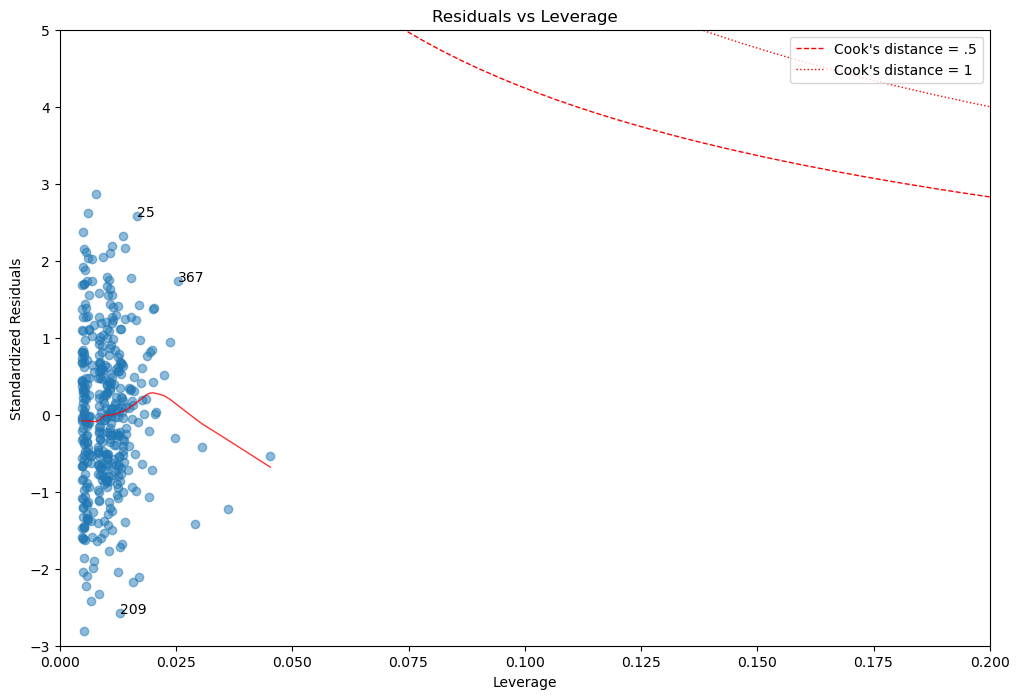

In [44]:
# Fitted values
model2_fitted_y = results_2.fittedvalues

# Normalized residuals
model2_norm_residuals = results_2.get_influence().resid_studentized

# Absolute squared normalized residuals
model2_norm_residuals_abs_sqrt = np.sqrt(np.abs(model2_norm_residuals))

# Leverage, from statsmodels internals
model2_leverage = results_2.get_influence().hat_matrix_diag

# Cook's distance
model2_cooks = results_2.get_influence().cooks_distance[0]

# Plot 4: residuals vs. leverage with Cook's distance
plot_lm_4 = plt.figure(4)
plot_lm_4.set_figheight(8)
plot_lm_4.set_figwidth(12)

plt.scatter(model2_leverage, model2_norm_residuals, alpha=0.5)
sns.regplot(x=model2_leverage, y=model2_norm_residuals, 
            scatter=False, 
            ci=False, 
            lowess=True,
            line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8})

plt.xlim(0, 0.20)
plt.ylim(-3, 5)
plt.title('Residuals vs Leverage')
plt.xlabel('Leverage')
plt.ylabel('Standardized Residuals')

# Annotations
leverage_top_3 = np.flip(np.argsort(model_cooks), 0)[:3]

for i in leverage_top_3:
    plt.annotate(i, 
                 xy=(model2_leverage[i], model2_norm_residuals[i]))

# Shenanigans for Cook's distance contours
def graph(formula, x_range, label=None, ls='-'):
    x = x_range
    y = formula(x)
    plt.plot(x, y, label=label, lw=1, ls=ls, color='red')

p = len(results_2.params) # number of model parameters

graph(lambda x: np.sqrt((0.5 * p * (1 - x)) / x), 
      np.linspace(0.001, 0.200, 50), 
      'Cook\'s distance = .5', ls='--') # 0.5 line

graph(lambda x: np.sqrt((1 * p * (1 - x)) / x), 
      np.linspace(0.001, 0.200, 50), 'Cook\'s distance = 1', ls=':') # 1 line

plt.legend(loc='upper right')
plt.show()


In [33]:
results_2.get_influence().summary_frame()

,dfb_const,dfb_Price,dfb_Urban_Yes,dfb_US_Yes,cooks_d,standard_resid,hat_diag,dffits_internal
0,-0.009962,0.003980,0.022370,0.025976,0.000657,0.735025,0.004843,0.051278
1,0.035644,-0.045303,0.020992,0.024579,0.000976,0.617078,0.010149,0.062485
2,0.005032,-0.006319,0.002716,0.003182,0.000018,0.079140,0.011119,0.008392
3,-0.019188,0.027183,-0.020391,-0.023805,0.000658,-0.624793,0.006694,-0.051292
4,0.006827,-0.021883,-0.026587,0.054667,0.001370,-0.772310,0.009102,-0.074019
...,...,...,...,...,...,...,...,...
395,-0.062433,0.048359,0.064029,0.074195,0.006214,2.156850,0.005314,0.157652
396,-0.008333,-0.006592,0.050976,-0.025737,0.001053,-0.637849,0.010243,-0.064889
397,-0.066831,0.066632,0.020189,0.023180,0.001799,0.751692,0.012573,0.084822
398,-0.043615,0.060273,-0.041424,-0.048382,0.002838,-1.261722,0.007080,-0.106543


In [34]:
import statsmodels.stats.api as sms
from statsmodels.compat import lzip
name = ["Jarque-Bera", "Chi^2 two-tail prob.", "Skew", "Kurtosis"]
test = sms.jarque_bera(results_2.get_influence().resid_studentized)
lzip(name, test)

[('Jarque-Bera', 0.7702470998561431),
 ('Chi^2 two-tail prob.', 0.6803665717706127),
 ('Skew', 0.09375326512166689),
 ('Kurtosis', 2.894851880152452)]

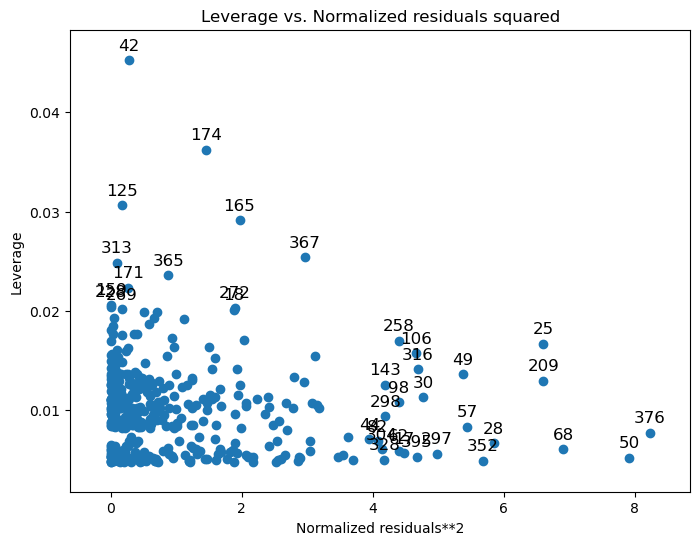

In [35]:
from statsmodels.graphics.regressionplots import plot_leverage_resid2

fig, ax = plt.subplots(figsize=(8, 6))
fig = plot_leverage_resid2(results_2, ax=ax)

In [36]:
np.linalg.cond(results_2.model.exog)

628.1875691223619

In [37]:
name = ["Lagrange multiplier statistic", "p-value", "f-value", "f p-value"]
test = sms.het_breuschpagan(results_2.get_influence().resid_studentized, results_2.model.exog)
lzip(name, test)

[('Lagrange multiplier statistic', 6.60325340807959),
 ('p-value', 0.08567818818879755),
 ('f-value', 2.2156498685299635),
 ('f p-value', 0.08579793161588857)]

In [45]:
vals = [VIF(X, i) for i in range(1, X.shape[1])]
vif = pd.DataFrame({'vif':vals}, index=X.columns[1:])
vif

,vif
Price,1.005342
Urban_Yes,1.004203
US_Yes,1.005349


## Example: Handling categorical data (Pandas)

Lets test the use of get_dummies in pandas

In [5]:
df_dummies = pd.get_dummies(df,drop_first=True)
df_dummies = sm.add_constant(df_dummies)
df_dummies

,const,Sales,Price,Urban_Yes,US_Yes
0,1.0,9.50,120,True,True
1,1.0,11.22,83,True,True
2,1.0,10.06,80,True,True
3,1.0,7.40,97,True,True
4,1.0,4.15,128,True,False
...,...,...,...,...,...
395,1.0,12.57,128,True,True
396,1.0,6.14,120,False,True
397,1.0,7.41,159,True,True
398,1.0,5.94,95,True,True


In [6]:
X = df_dummies.drop(columns='Sales')
y = df_dummies['Sales']
model_3 = sm.OLS(y, X.astype(float))
results_3 = model_3.fit()
results_3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Sales   R-squared:                       0.239
Model:                            OLS   Adj. R-squared:                  0.234
Method:                 Least Squares   F-statistic:                     41.52
Date:                Sun, 19 May 2024   Prob (F-statistic):           2.39e-23
Time:                        10:52:55   Log-Likelihood:                -927.66
No. Observations:                 400   AIC:                             1863.
Df Residuals:                     396   BIC:                             1879.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         13.0435      0.651     20.036      0.000      11.764      14.323
Price         -0.0545      0.005    -10.389      0.000      -0.065      -0.044
Urban_Yes     -0.0219      0.272     -0.081      0.936      -0.556       0.512
US_Yes         1.2006      0.259      4.635      0.000       0.691       1.710
==============================================================================
Omnibus:                        0.676   Durbin-Watson:                   1.912
Prob(Omnibus):                  0.713   Jarque-Bera (JB):                0.758
Skew:                           0.093   Prob(JB):                        0.684
Kurtosis:                       2.897   Cond. No.                         628.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

df = n - (k+1)

We interpret these results as follows: for a given amount of Price and Urban_Yes, US_Yes, reducing an additional $1,000 on the Price is associated with approximately 5 units of additional sales.

For the advertising data, the p-value associated with the F-statistic is essentially zero, so we have extremely strong evidence that at least one of the media is associated with increased sales.

R squared: The degree to which the dependent variables in (x) explain the variation in the dependent variable (y). In our case, we can say that 23% variance is explained by the model. The disadvantage of an R2 score is that as the number of variables in x increases, R2 tends to remain constant or even increase by a small amount. The new variable, on the other hand, may or may not be significant.

Adj. R square: This overcomes the disadvantage of the R2 score and is thus considered more reliable. Adj. R2 does not consider variables that are “not significant” for the model.

In [7]:
vals = [VIF(X.astype(float), i) for i in range(1, X.shape[1])]
vif = pd.DataFrame({'vif':vals}, index=X.columns[1:])
vif

,vif
Price,1.005342
Urban_Yes,1.004203
US_Yes,1.005349


Residual standard error

In [8]:
np.sqrt(np.sum(results_3.resid**2)/results_3.df_resid)

2.4724924402701642

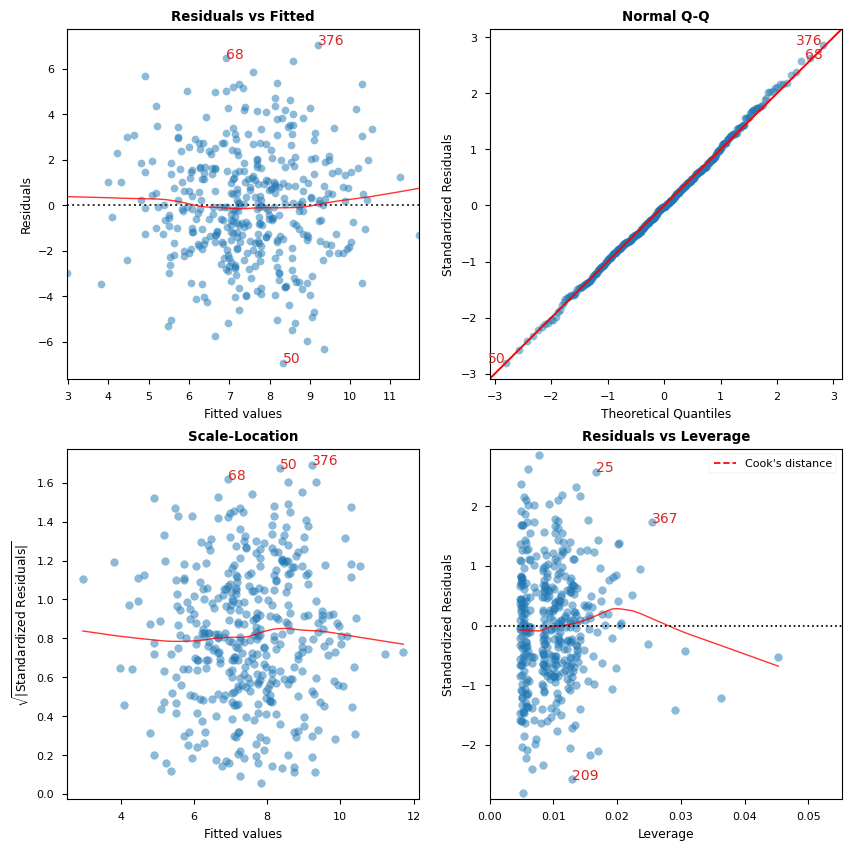

,Features,VIF Factor
2,Urban_Yes,1.00
1,Price,1.01
3,US_Yes,1.01
0,const,27.73


In [9]:
cls = LinearRegDiagnostic(results_3)
vif, fig, ax = cls()
vif

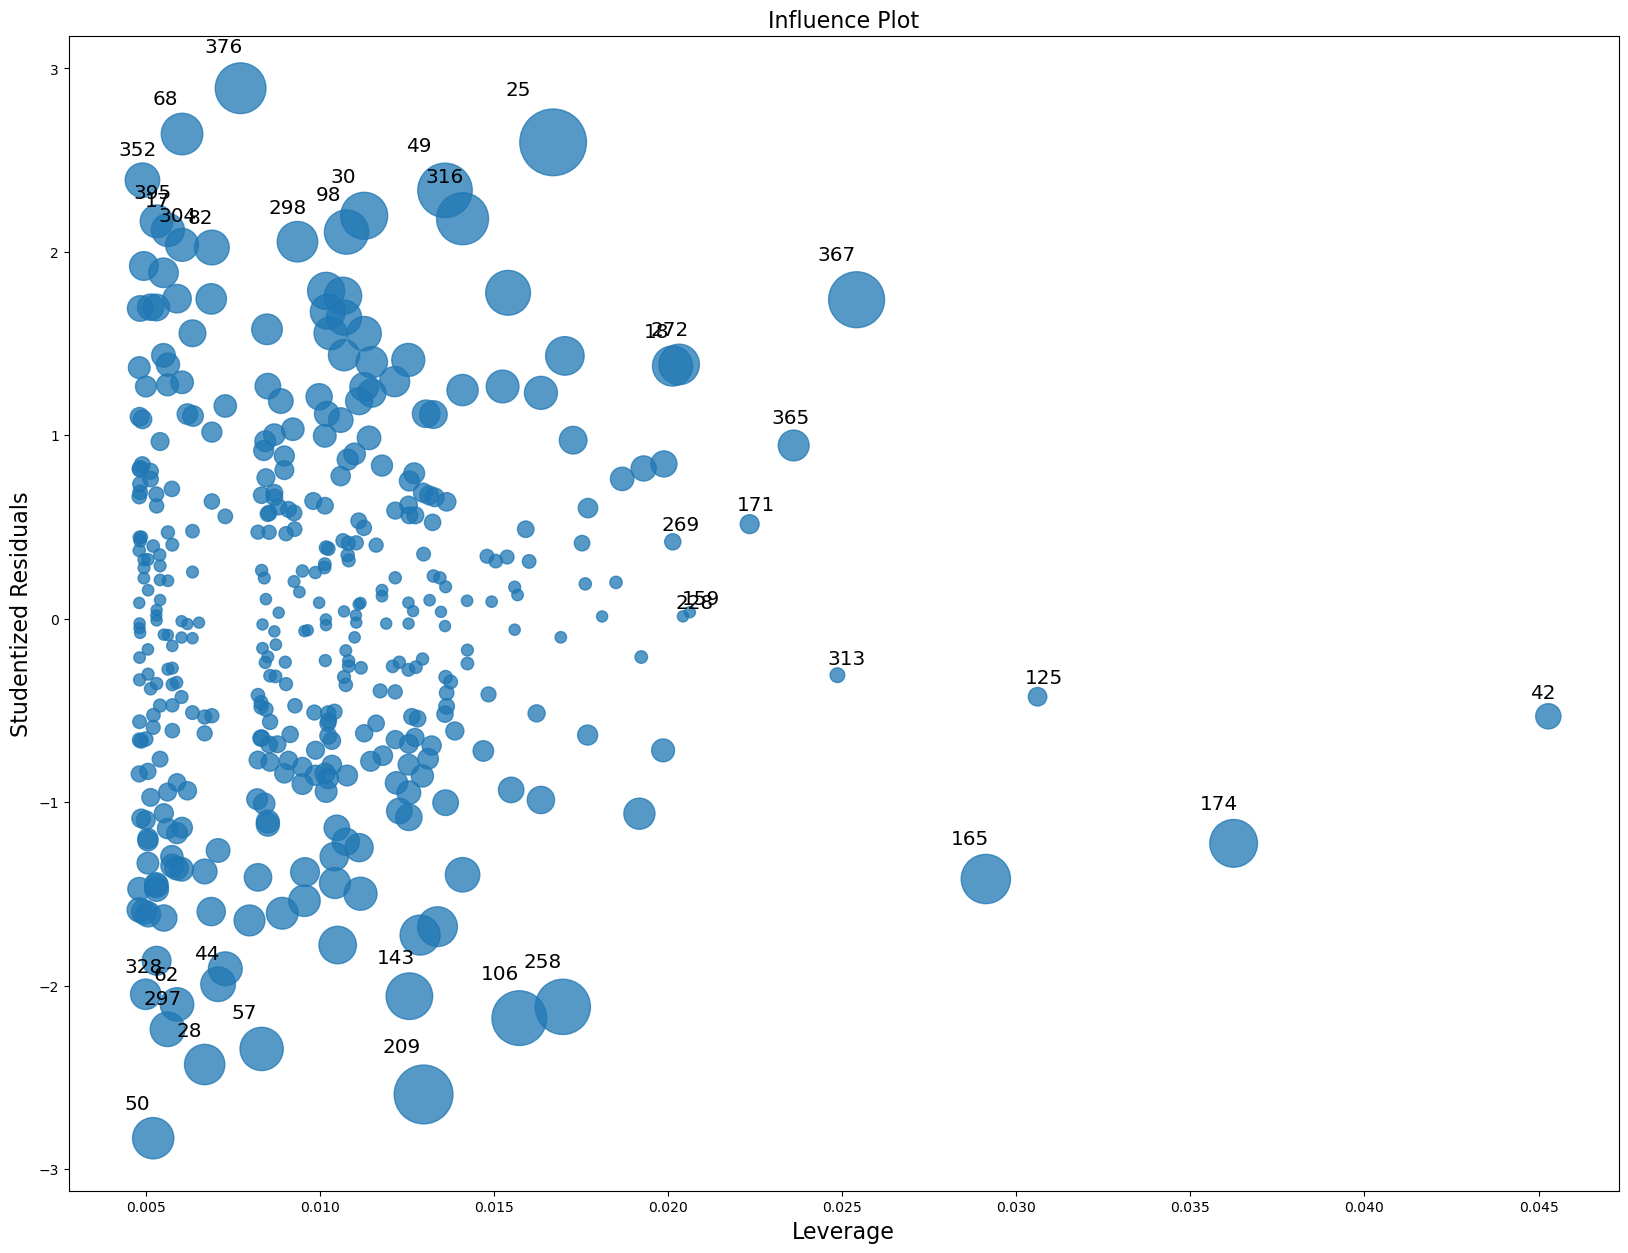

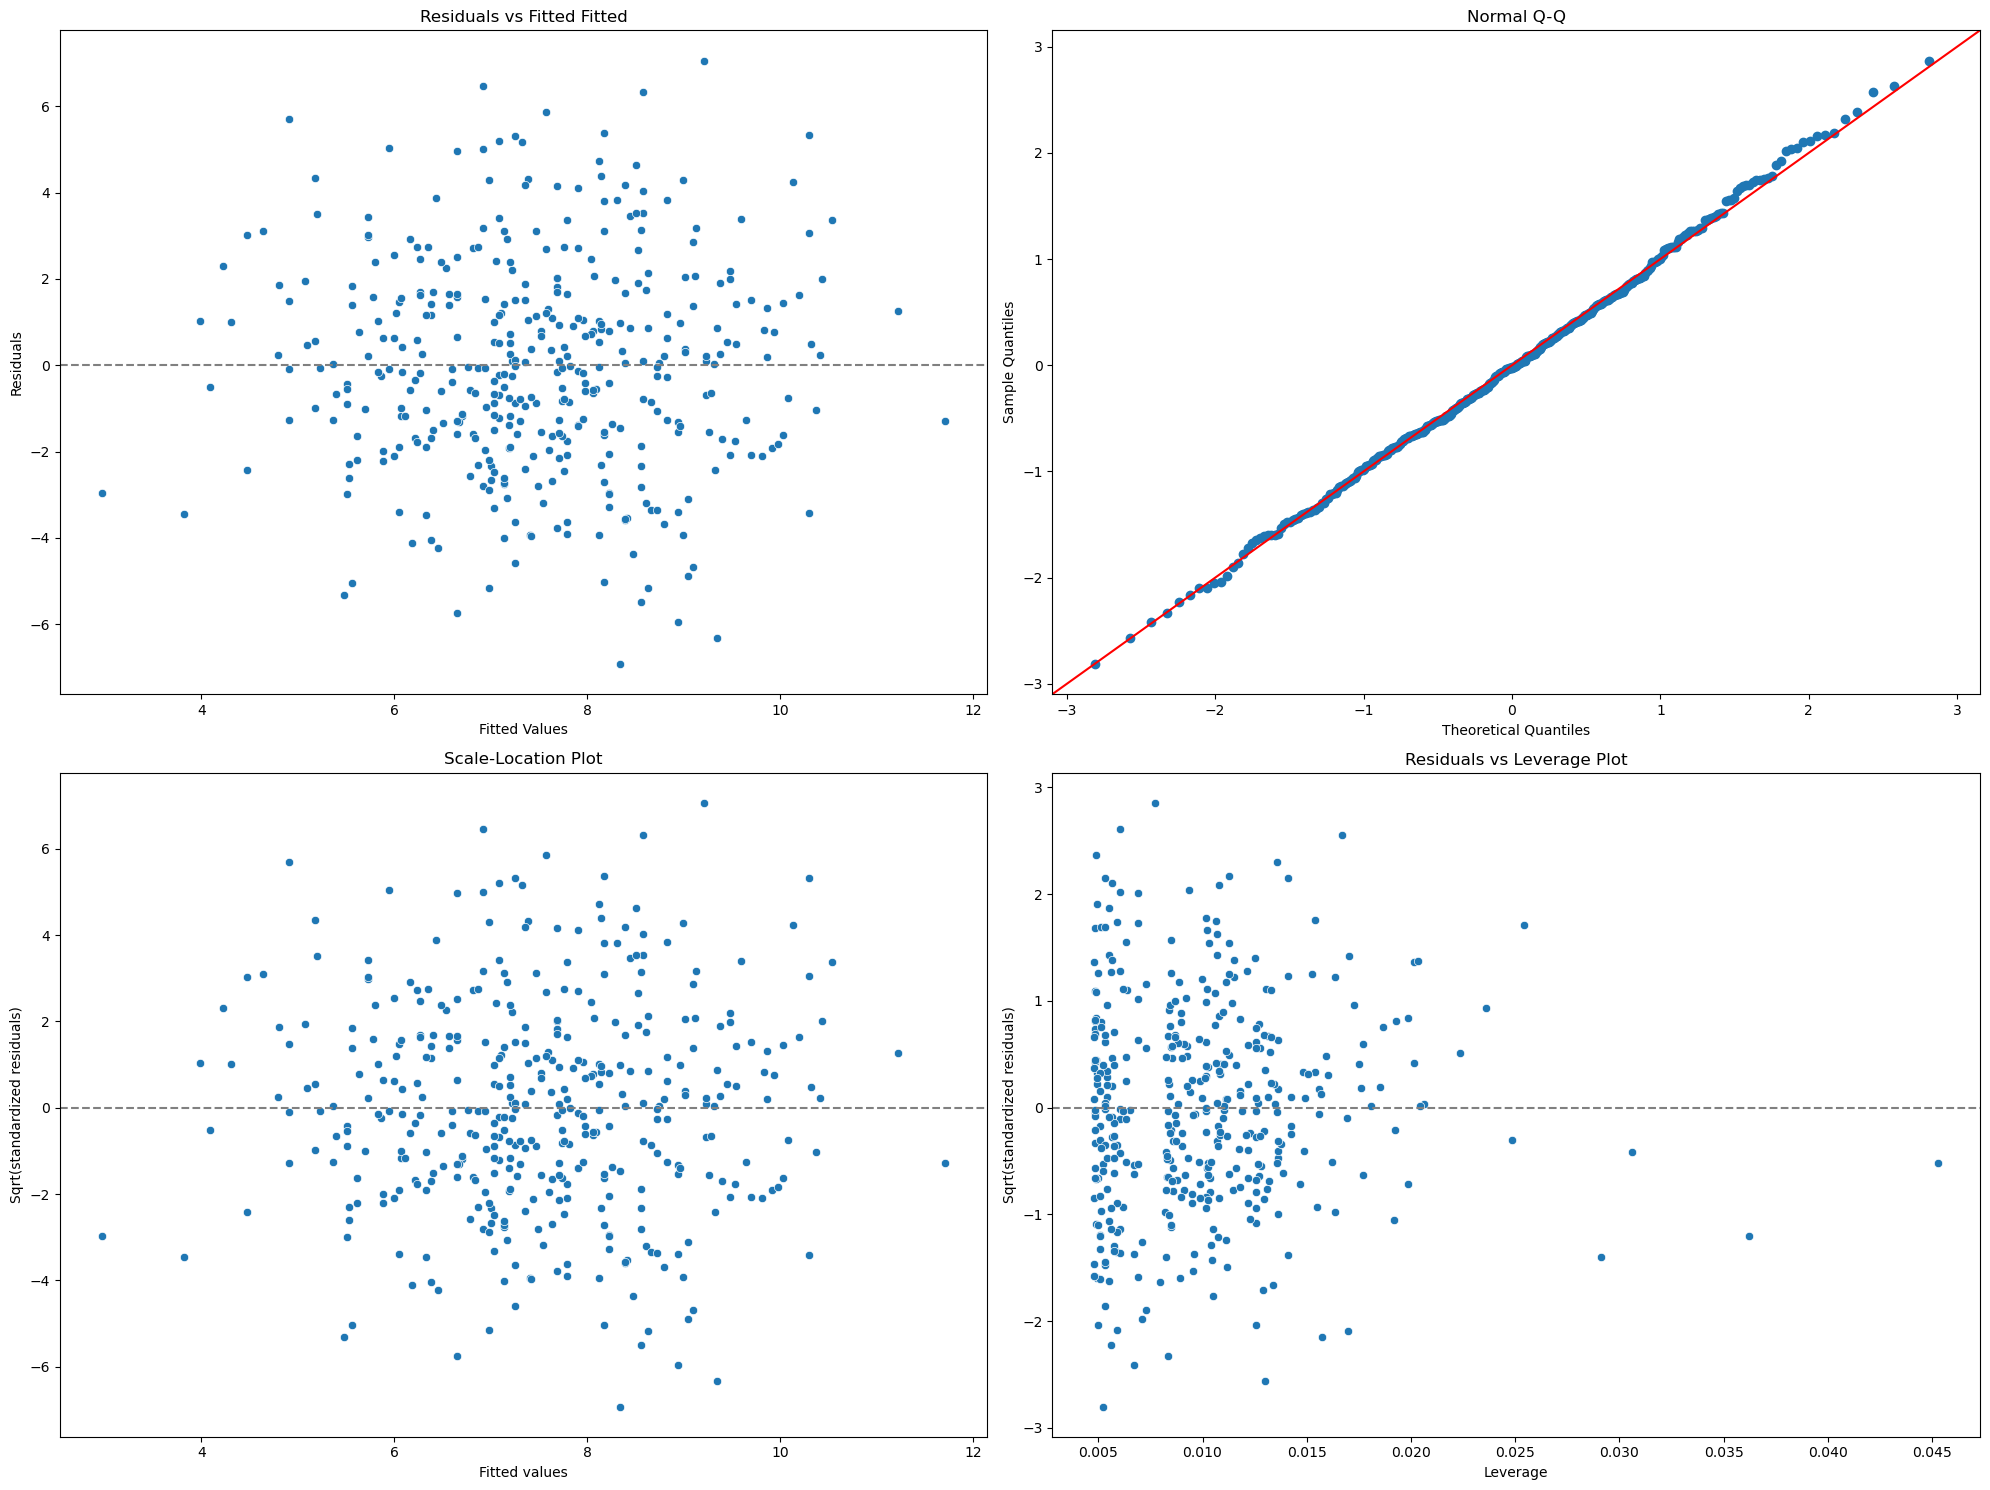

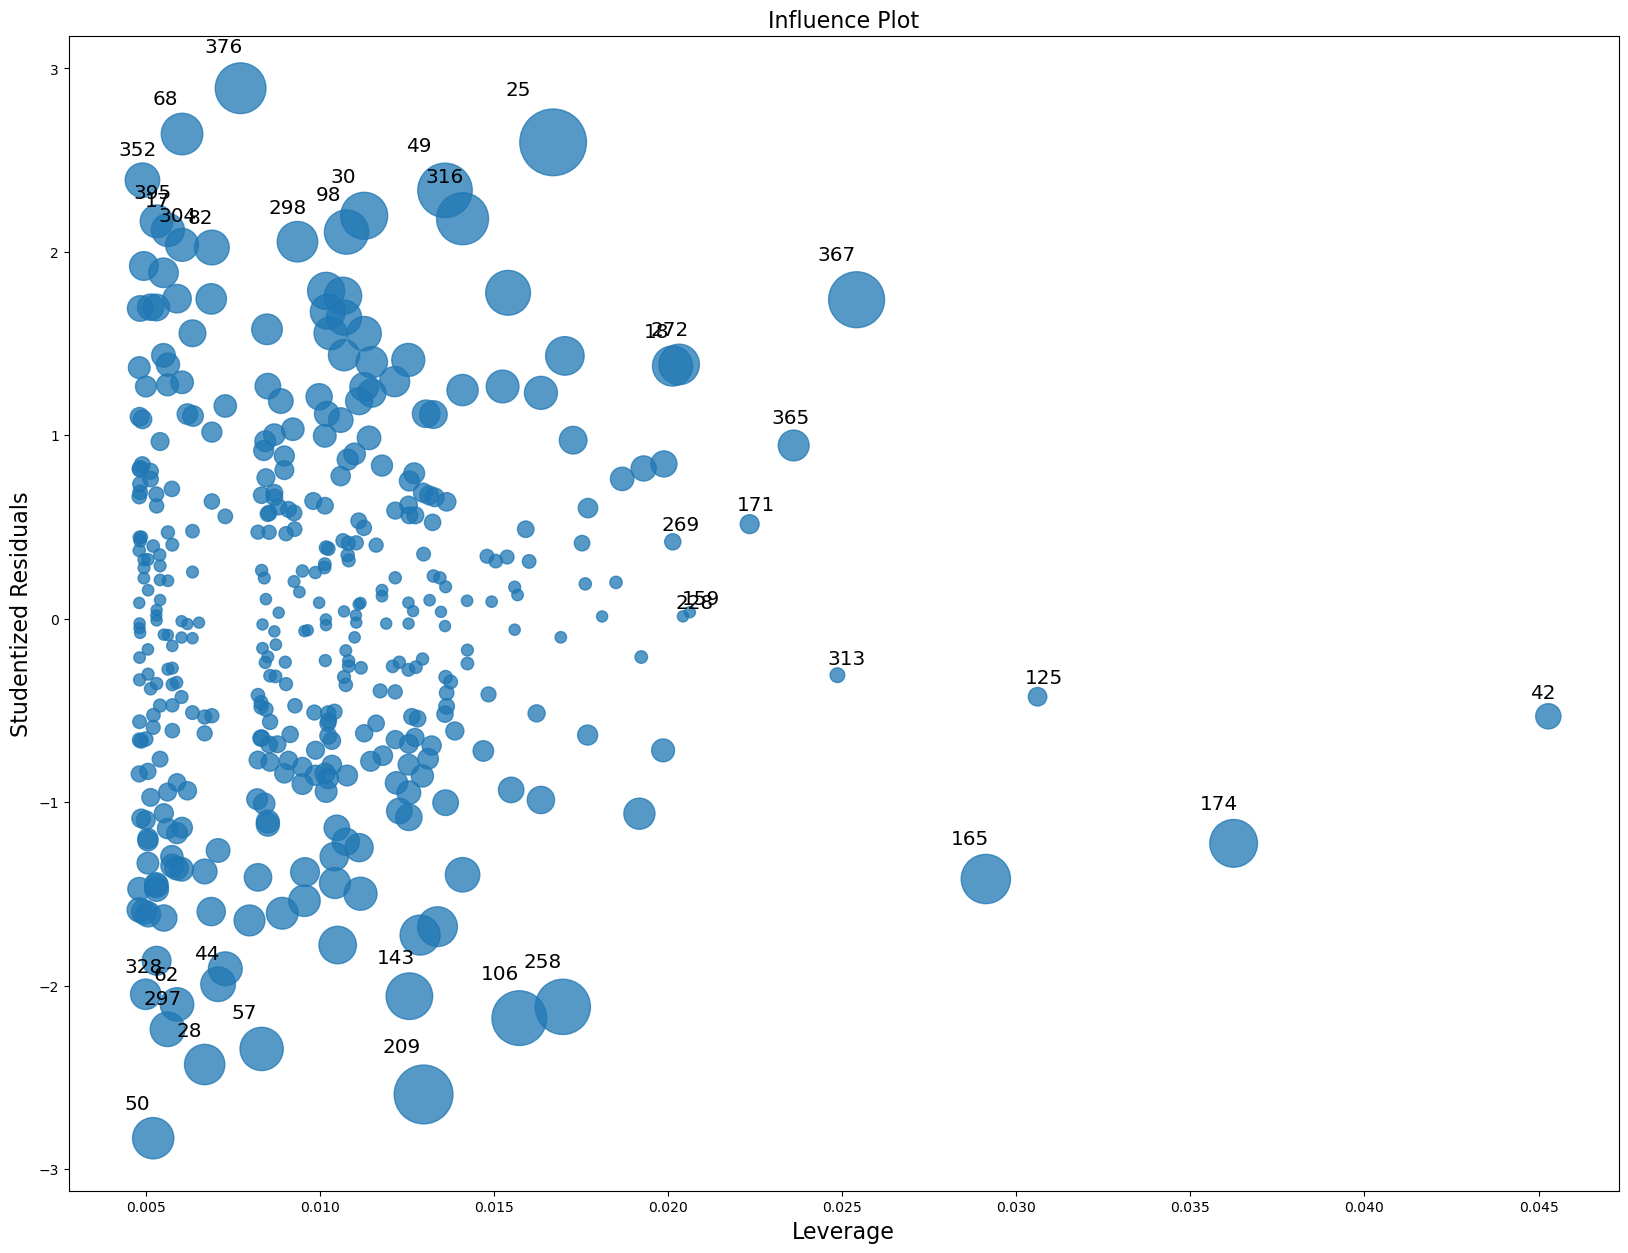

In [12]:
# Get different Variables for diagnostic 
residuals = results_3.resid 
fitted_value = results_3.fittedvalues 
stand_resids = results_3.resid_pearson 
influence = results_3.get_influence() 
leverage = influence.hat_matrix_diag 

# PLot different diagnostic plots 
plt.rcParams["figure.figsize"] = (20,15) 
fig, ax = plt.subplots(nrows=2, ncols=2) 
  
# Residual vs Fitted Plot 
sns.scatterplot(x=fitted_value, y=residuals, ax=ax[0, 0]) 
ax[0, 0].axhline(y=0, color='grey', linestyle='dashed') 
ax[0, 0].set_xlabel('Fitted Values') 
ax[0, 0].set_ylabel('Residuals') 
ax[0, 0].set_title('Residuals vs Fitted Fitted') 
  
# Normal Q-Q plot 
sm.qqplot(residuals, fit=True, line='45',ax=ax[0, 1]) 
ax[0, 1].set_title('Normal Q-Q') 
  
# Scale-Location Plot 
sns.scatterplot(x=fitted_value, y=residuals, ax=ax[1, 0]) 
ax[1, 0].axhline(y=0, color='grey', linestyle='dashed') 
ax[1, 0].set_xlabel('Fitted values') 
ax[1, 0].set_ylabel('Sqrt(standardized residuals)') 
ax[1, 0].set_title('Scale-Location Plot') 
  
# Residual vs Leverage Plot 
sns.scatterplot(x=leverage, y=stand_resids, ax=ax[1, 1]) 
ax[1, 1].axhline(y=0, color='grey', linestyle='dashed') 
ax[1, 1].set_xlabel('Leverage') 
ax[1, 1].set_ylabel('Sqrt(standardized residuals)') 
ax[1, 1].set_title('Residuals vs Leverage Plot') 
  
  
plt.tight_layout() 
plt.show() 
  
# PLot Cook's distance plot 
sm.graphics.influence_plot(results_3, criterion="cooks")

In other words, actual sales in each market deviate from the true regression line by approximately 2472 units, on average. Of course, whether or not 2472 units is an acceptable prediction error depends on the problem context. In the advertising data set, the mean value of sales over all markets is approximately 14,000 units, and so the percentage error is 2472/14000 = 18%.

**Assessing the Accuracy of the Coefficient Estimates:**
We do this by looking at the output of Statsmodels pertaining to the coef, std err, t, p-value, and confidence bounds (2.5% to 97.5%). The coefficient direction should make intuitive sense (if price goes down will sales go up?), the standard error of the coefficient tells us how close the predicted coefficients are to the true coefficients (these values influence the p-values and confidence bounds), but keep in mind these values strictly assume the assumption that the errors are normally distributed and have common variance where the residual standard error can be computed to assess the variance. The confidence bounds are such that A 95% confidence interval has the following property: if we take repeated samples and construct the confidence interval for each sample, 95% of the intervals will contain the true unknown value of the parameter. The p-value is used for the test H0:There is no relationship between X and Y (if p-value < 0.05 this is rejected, that is, we declare a relationship to exist between the independent variable and Y). 

**Assessing the Accuracy of the Model:**
Once we have rejected the null hypothesis in favor of the alternative hypothesis, it is natural to want to quantify the extent to which the model fits the data. The quality of a linear regression fit is typically assessed using two related quantities: the residual standard error (RSE), the R-Squared statistic and the F-statistic. R2 measures the proportion of variability in Y that can be explained using X. An R2 statistic that is close to 1 indicates that a large proportion of the variability in the response is explained by the regression. A number near 0 indicates that the regression does not explain much of the variability in the response; this might occur because the linear model is wrong, or the error variance is high, or both. R2 will always increase when more variables are added to the model, even if those variables are only weakly associated with the response. This is due to the fact that adding another variable always results in a decrease in the residual sum of squares on the training data (though not necessarily the testing data). Thus, the R2 statistic, which is also computed on the training data, must increase. The fact that adding Urban_Yes advertising to the model containing only US_Yes and Price advertising leads to just a tiny increase in R2 provides additional evidence that Urban_Yes can be dropped from the model. Essentially, Urban_Yes provides no real improvement in the model fit to the training samples, and its inclusion will likely lead to poor results on independent test samples due to overfitting.

- Omnibus (D’Angostino’s test): Establishes whether the samples come from a normally distributed population. It determines whether the explained variance in a set of data is significantly greater than the unexplained variance in the aggregate. We hope that the Omnibus score is close to 0 and the probability is close to 1, indicating that the residuals follow normalcy. a test of the skewness and kurtosis of the residual. We hope to see a value close to zero which would indicate normalcy. The Prob (Omnibus) performs a statistical test indicating the probability that the residuals are normally distributed. We hope to see something close to 1 here.
- Prob(Omnibus) : Probability of Omnibus. Probability that the residuals are normally distributed according to omnibus statistic. 
- Durbin-Watson: Test to see if the errors are not independent. Used to find repeating patterns that may be obstructed by noise. Its value lies between 0 and 4. If greater than 2 this is a sign that relationships between two variables are going in opposite directions (negatively correlated). If less than 2 variables are positively correlated. The null hypothesis is based on the assumption that there is no autocorrelation. The test’s value ranges from 0 to 4. If the test value is 2, there is no auto correlation. We hope to have a value between 1 and 2.
- Jarque-Bera: Tests whether the samples match a normal distribution. It never has a negative number and the further it gets from zero signals the data doesn't have a normal distribution. Also a normality test using skewness and kurtosis, as an alternative way to omnibus statistic. We need JB and Omnibus mutually confirm with each other. 
- Prob(JB): The probability of Jarque-Bera
- Skew: Measure of the asymmetry of the probability distribution. Negative skew indicates the tail is longer on the left and the concentration of the data is on the right. Positive indicates the tail is longer on the right. 0 indicates that the tails are balanced. Note that this value also drives the Omnibus.
- Kurtosis: Describes the shape of a probability distribution with a focus on the tails and not the peak. If the value is high that is a sign that there are more outliers. If the value is less than 3 that means there are fewer outliers. A value of 3 points towards a normal distribution. Values greater than 3 indicate more outliers.
- Condition Number: Represents whether samples are highly correlated in our regression model. A large number indicates strong multicollinearity which means that independent variables are highly correlated with each other. This causes problems because a small number of samples are so dramatically different from others that results are corrupted. We hope to see a relatively small number, something below 30.

Omnibus is a statistical test for the normality assumption of the residuals in a linear regression model. The Omnibus test statistic is calculated based on the skewness and kurtosis of the residuals. It tests the null hypothesis that the residuals are normally distributed against the alternative hypothesis that the residuals are not normally distributed. If the Omnibus test statistic is large and the associated p-value is small (typically less than 0.05), it suggests that the normality assumption of the residuals is violated, and the residuals are not normally distributed. This may indicate that the regression model is misspecified or that there are other underlying problems with the data. On the other hand, if the Omnibus test statistic is small and the associated p-value is large (typically greater than 0.05), it suggests that there is no evidence to reject the normality assumption of the residuals, and the residuals are likely to be normally distributed. This indicates that the regression model is a good fit for the data.

Prob (omnibus): Prob(Omnibus) is the p-value associated with the Omnibus test statistic, which tests the null hypothesis that the residuals in a linear regression model are normally distributed. The Prob(Omnibus) value indicates the probability of obtaining the observed Omnibus test statistic or a more extreme value, assuming that the null hypothesis is true. A small Prob(Omnibus) value (typically less than 0.05) indicates that there is evidence to reject the null hypothesis and suggests that the residuals are not normally distributed. On the other hand, a large Prob(Omnibus) value (typically greater than 0.05) indicates that there is no evidence to reject the null hypothesis and suggests that the residuals are likely to be normally distributed. In general, a low Prob(Omnibus) value indicates that there may be problems with the linear regression model and the assumptions underlying the model, such as nonlinearity or heteroscedasticity in the data. It is important to investigate these issues further and consider alternative models if necessary. Therefore, the Prob(Omnibus) value is an important output in the summary() function of Statsmodels and can be used to evaluate the goodness of fit of the linear regression model.

Jarque-Bera (JB): The Jarque-Bera (JB) test is a goodness-of-fit test that is used to test whether the residuals in a linear regression model are normally distributed. In the Statsmodels summary() function, the JB test is included as one of the outputs. The JB test statistic is based on the sample skewness and kurtosis of the residuals. Under the null hypothesis of normality, the JB test statistic follows a chi-squared distribution with 2 degrees of freedom. Therefore, if the p-value associated with the JB test statistic is small (typically less than 0.05), we reject the null hypothesis of normality and conclude that the residuals are not normally distributed. The JB test is important in the summary() function because it helps to assess whether the assumption of normality of the residuals is met. If the residuals are not normally distributed, it suggests that the linear regression model may not be the best fit for the data and that alternative models or transformations may be necessary.

Prob (JB): Prob(JB) represents the p-value associated with the Jarque-Bera (JB) test statistic. The JB test is a goodness-of-fit test used to assess whether the residuals in a linear regression model are normally distributed. The null hypothesis of the JB test is that the residuals are normally distributed, and the alternative hypothesis is that they are not. If the p-value associated with the JB test is small (typically less than 0.05), we reject the null hypothesis and conclude that the residuals are not normally distributed. Therefore, the Prob(JB) value in the summary() function is the probability of observing a JB test statistic as large as or larger than the one observed, assuming that the residuals are normally distributed. If the Prob(JB) value is small, it suggests that the residuals are not normally distributed, and we should consider alternative models or transformations to better capture the underlying distribution of the data. If the Prob(JB) value is large (typically greater than 0.05), it suggests that the residuals are normally distributed, which supports the validity of the linear regression model.

Condition No: is a measure of the sensitivity of the model to changes in the input variables. Specifically, the condition number indicates how much the output of the model will change in response to small changes in the input variables. A large condition number indicates that the model is highly sensitive to changes in the input variables, which can be problematic for several reasons. For example, a large condition number may indicate that the input variables are highly correlated, which can lead to instability in the model estimates or inflated standard errors. In the context of a linear regression model, a condition number greater than 30 is often considered high, and values greater than 100 are generally indicative of severe multicollinearity (high correlation among predictor variables). Therefore, it is recommended to keep the condition number as low as possible to ensure that the model is stable and reliable. If the condition number is too high, it may be necessary to consider alternative modelling strategies or to re-evaluate the input variables to identify any sources of multicollinearity.

# ISLR Applied EXERCISE 3.8

In [3]:
dir_data = PATH / Path('data')
input_file = 'Auto.csv'
file_path_data = dir_data / Path(input_file)

There are different ways in practice to deal with missing values, however, we will look into this in the future.

In [4]:
df = pd.read_csv(file_path_data, na_values = ["?"])
df = df.dropna() # drop all missing values
df

,mpg,cylinders,displacement,horsepower,weight,acceleration,year,origin,name
0,18.0,8,307.0,130.0,3504,12.0,70,1,chevrolet chevelle malibu
1,15.0,8,350.0,165.0,3693,11.5,70,1,buick skylark 320
2,18.0,8,318.0,150.0,3436,11.0,70,1,plymouth satellite
3,16.0,8,304.0,150.0,3433,12.0,70,1,amc rebel sst
4,17.0,8,302.0,140.0,3449,10.5,70,1,ford torino
...,...,...,...,...,...,...,...,...,...
392,27.0,4,140.0,86.0,2790,15.6,82,1,ford mustang gl
393,44.0,4,97.0,52.0,2130,24.6,82,2,vw pickup
394,32.0,4,135.0,84.0,2295,11.6,82,1,dodge rampage
395,28.0,4,120.0,79.0,2625,18.6,82,1,ford ranger


In [5]:
df = sm.add_constant(df)
df

,const,mpg,cylinders,displacement,horsepower,weight,acceleration,year,origin,name
0,1.0,18.0,8,307.0,130.0,3504,12.0,70,1,chevrolet chevelle malibu
1,1.0,15.0,8,350.0,165.0,3693,11.5,70,1,buick skylark 320
2,1.0,18.0,8,318.0,150.0,3436,11.0,70,1,plymouth satellite
3,1.0,16.0,8,304.0,150.0,3433,12.0,70,1,amc rebel sst
4,1.0,17.0,8,302.0,140.0,3449,10.5,70,1,ford torino
...,...,...,...,...,...,...,...,...,...,...
392,1.0,27.0,4,140.0,86.0,2790,15.6,82,1,ford mustang gl
393,1.0,44.0,4,97.0,52.0,2130,24.6,82,2,vw pickup
394,1.0,32.0,4,135.0,84.0,2295,11.6,82,1,dodge rampage
395,1.0,28.0,4,120.0,79.0,2625,18.6,82,1,ford ranger


In [6]:
df.dtypes

const           float64
mpg             float64
cylinders         int64
displacement    float64
horsepower      float64
weight            int64
acceleration    float64
year              int64
origin            int64
name             object
dtype: object

In [7]:
X = df[['const', 'horsepower']].astype('float')
y = df['mpg']
model = sm.OLS(y, X)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    mpg   R-squared:                       0.606
Model:                            OLS   Adj. R-squared:                  0.605
Method:                 Least Squares   F-statistic:                     599.7
Date:                Sun, 19 May 2024   Prob (F-statistic):           7.03e-81
Time:                        11:05:39   Log-Likelihood:                -1178.7
No. Observations:                 392   AIC:                             2361.
Df Residuals:                     390   BIC:                             2369.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         39.9359      0.717     55.660      0.000      38.525      41.347
horsepower    -0.1578      0.006    -24.489      0.000      -0.171      -0.145
==============================================================================
Omnibus:                       16.432   Durbin-Watson:                   0.920
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               17.305
Skew:                           0.492   Prob(JB):                     0.000175
Kurtosis:                       3.299   Cond. No.                         322.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

For a unit increase in horsepower, our model predicts mpg will decrease by -0.1578. So for example, increasing horsepower by 10 is expected to decrease efficiency by -1.578 mpg.

In [8]:
results.params.iloc[0]

39.93586102117047

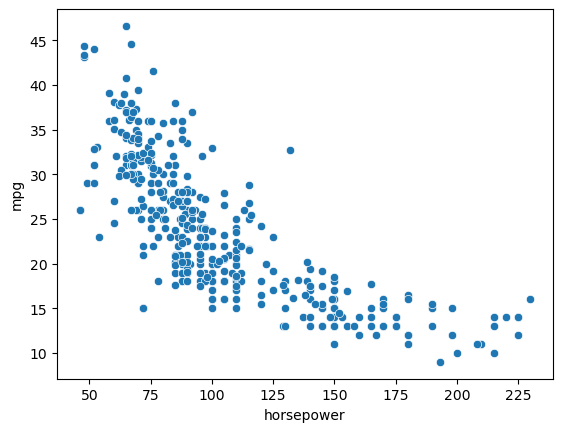

In [9]:
ax = sns.scatterplot(x='horsepower', y='mpg', data=df)

<Axes: xlabel='horsepower', ylabel='mpg'>

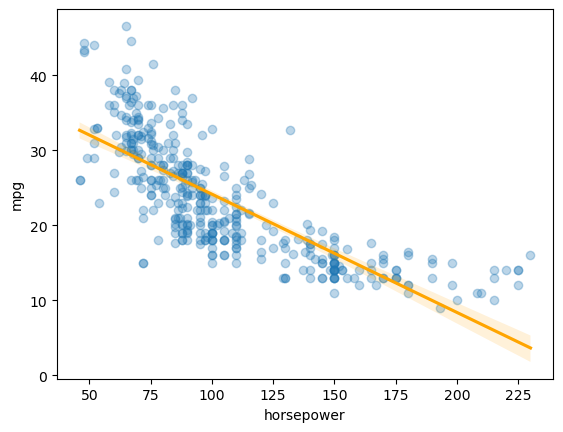

In [10]:
sns.regplot(x = "horsepower", y = "mpg", data = df, scatter_kws = {"alpha": 0.3}, line_kws = {"color": "orange"})

In [11]:
results.fittedvalues


0      19.416046
1      13.891480
2      16.259151
3      16.259151
4      17.837598
         ...    
392    26.361214
393    31.727935
394    26.676903
395    27.466127
396    26.992593
Length: 392, dtype: float64

In [12]:
results.get_influence().summary_frame()

,dfb_const,dfb_horsepower,cooks_d,standard_resid,hat_diag,dffits_internal,student_resid,dffits
0,0.004062,-0.009707,0.000154,-0.289182,0.003676,-0.017566,-0.288842,-0.017545
1,-0.013024,0.018109,0.000231,0.226973,0.008876,0.021479,0.226696,0.021453
2,-0.013802,0.021335,0.000391,0.355951,0.006130,0.027954,0.355552,0.027922
3,0.002054,-0.003176,0.000009,-0.052989,0.006130,-0.004161,-0.052921,-0.004156
4,0.004518,-0.007998,0.000070,-0.171143,0.004730,-0.011799,-0.170930,-0.011784
...,...,...,...,...,...,...,...,...
392,0.005246,-0.003166,0.000027,0.130416,0.003140,0.007319,0.130252,0.007310
393,0.208413,-0.174917,0.023189,2.510749,0.007303,0.215357,2.528043,0.216840
394,0.046476,-0.029285,0.001940,1.086852,0.003274,0.062293,1.087106,0.062308
395,0.005329,-0.003650,0.000022,0.109026,0.003671,0.006618,0.108888,0.006609


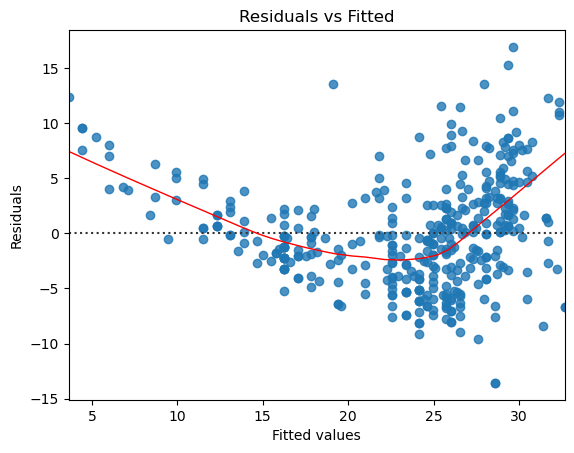

In [13]:
# Fitted values
model1_fitted_y = results.fittedvalues

# Normalized residuals
model1_norm_residuals = results.get_influence().resid_studentized_internal

# Absolute squared normalized residuals
model1_norm_residuals_abs_sqrt = np.sqrt(np.abs(model1_norm_residuals))

# Leverage, from statsmodels internals
model1_leverage = results.get_influence().hat_matrix_diag

# Plot 1: residuals vs. fitted values
plot1 = plt.figure(1)
sns.residplot(x=model1_fitted_y, y=df['mpg'], lowess=True, line_kws={'color': 'red', 'lw': 1})
plt.title('Residuals vs Fitted')
plt.xlabel('Fitted values')
plt.ylabel('Residuals')
plt.show()

Non-linearity of the data: The top-left residual plot exhibits a discernable pattern, in this case u-shaped, that suggests our linear model is not providing a optimal fit to our data - the relationship is non-linear. A discernable pattern in this plot suggests that our model is failing to account for some of the reducible variance in the responses. There is still a discernable pattern in the bottom-left plot suggesting that a quadratic transform only improves the fit of our model slightly.

The funnel shape of the plotted residuals indicates that we are in the presence of heteroscedasticity.

Text(0, 0.5, 'Standardized residuals')

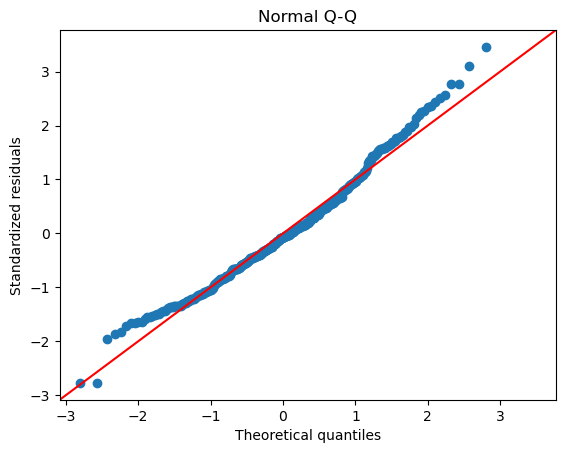

In [14]:
# plot 2: normal Q-Q
plot2 = sm.qqplot(model1_norm_residuals, fit=True, line='45')
plot2.axes[0].set_title('Normal Q-Q')
plot2.axes[0].set_xlabel('Theoretical quantiles')
plot2.axes[0].set_ylabel('Standardized residuals')

Plot shows that our studentised residuals have a slightly non-normal distribution

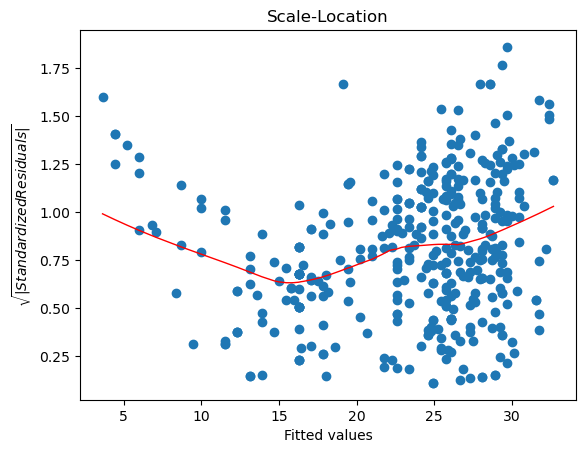

In [15]:
# Fitted values
model1_fitted_y = results.fittedvalues

# Normalized residuals
model1_norm_residuals = results.get_influence().resid_studentized_internal

# Absolute squared normalized residuals
model1_norm_residuals_abs_sqrt = np.sqrt(np.abs(model1_norm_residuals))

# Leverage, from statsmodels internals
model1_leverage = results.get_influence().hat_matrix_diag

# Plot 3: scale-location
plot3 = plt.figure(3)
plt.scatter(model1_fitted_y, model1_norm_residuals_abs_sqrt)
sns.regplot(x=model1_fitted_y, y=model1_norm_residuals_abs_sqrt, scatter=False, ci=False, lowess=True, line_kws={'color': 'red', 'lw': 1})
plt.title('Scale-Location')
plt.xlabel('Fitted values')
plt.ylabel('$\sqrt{|Standardized Residuals|}$')
plt.show()

Heteroscedasticity – Non-constant variance of error terms The residual plot exhibits a conical shape. This suggests that there is some heteroscedasticity in our predictor. The standardised plot also exhibits this characteristic suggesting that standardisation doesn't alleviate the issue – to address this we might consider fitting our model by weighted least squares.

It is clear from the plot that the assumption of homoscedasticity is not held.

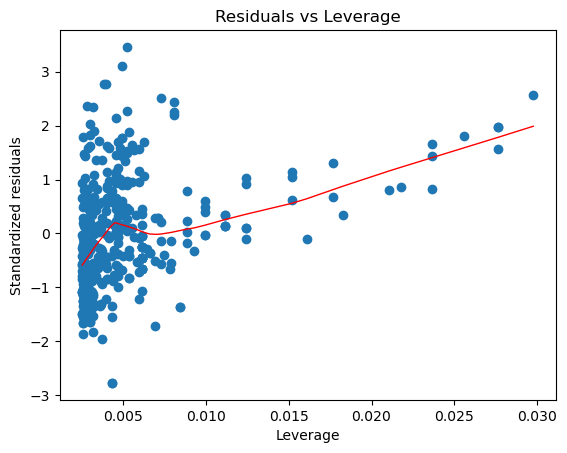

In [16]:
# Fitted values
model1_fitted_y = results.fittedvalues

# Normalized residuals
model1_norm_residuals = results.get_influence().resid_studentized_internal

# Absolute squared normalized residuals
model1_norm_residuals_abs_sqrt = np.sqrt(np.abs(model1_norm_residuals))

# Leverage, from statsmodels internals
model1_leverage = results.get_influence().hat_matrix_diag

# Plot 4: residuals vs. leverage
plot4 = plt.figure(4)
plt.scatter(model1_leverage, model1_norm_residuals)
sns.regplot(x=model1_leverage, y=model1_norm_residuals, scatter=False, ci=False, lowess=True, line_kws={'color': 'red', 'lw': 1})
plt.title('Residuals vs Leverage')
plt.xlabel('Leverage')
plt.ylabel('Standardized residuals')
plt.show()


Outliers and leverage: the residual vs leverage plot suggests that there are several potential outliers (points in top-right of axis) that could be having a strong effect (leverage) on our model. We should add more predictors to our model to clarify outliers.

https://sphweb.bumc.bu.edu/otlt/MPH-Modules/BS/R/R5_Correlation-Regression/R5_Correlation-Regression7.html

Looking at the Residuals vs. Fitted plot, there is a clear U-shape to the residuals, which is a strong indicator of non-linearity in the data. This, when combined with an inspection of the plot in Part 2, tells us that the simple linear regression model is not a good fit. In addition, when looking at the Residuals vs. Leverage plot, there are some high leverage points (remember that after dropping the rows with null values, there are 392 observations in the data set, giving an average leverage value of  2/392≈0.0051
 ) which also have high standardized residual values (greater than 2), which is also of concern for the simple linear regression model. There are also a number of observations with a standardized residual value of 3 or more, which is evidence to suggest that they would be possibile outliers if we didn't already have the suspicion that the data is non-linear.

Scale-location plot: It is clear from the plot that the assumption of homoscedasticity is not held.

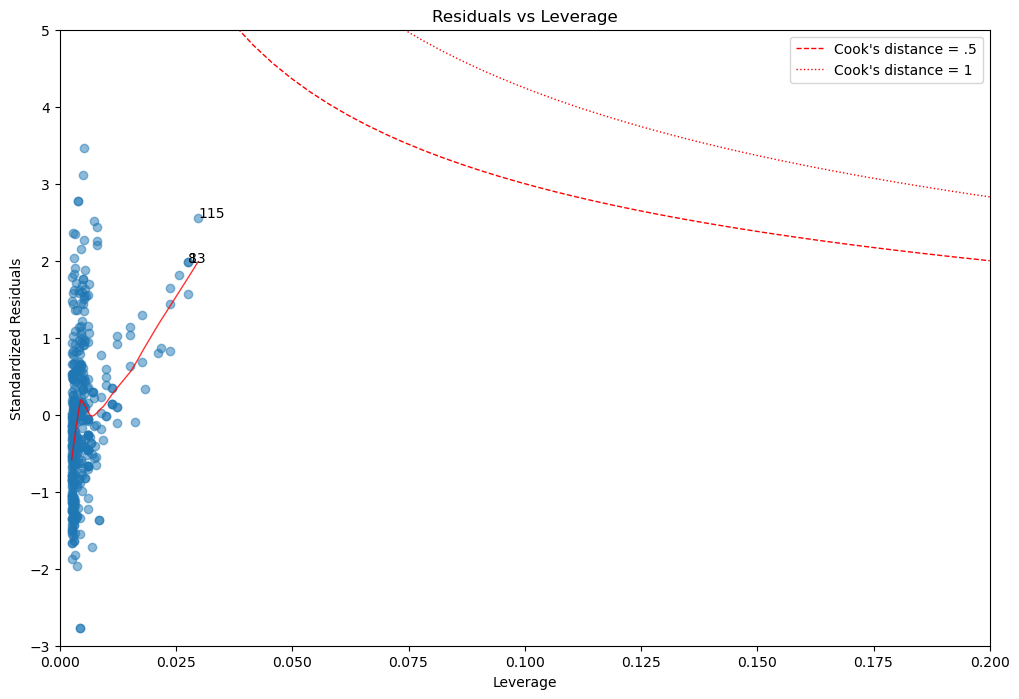

In [17]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming results and df are already defined

# Fitted values
model1_fitted_y = results.fittedvalues

# Normalized residuals
model1_norm_residuals = results.get_influence().resid_studentized_internal

# Absolute squared normalized residuals
model1_norm_residuals_abs_sqrt = np.sqrt(np.abs(model1_norm_residuals))

# Leverage, from statsmodels internals
model1_leverage = results.get_influence().hat_matrix_diag

# Cook's distance
model_cooks = results.get_influence().cooks_distance[0]

# Plot 4: residuals vs. leverage with Cook's distance
plot_lm_4 = plt.figure(4)
plot_lm_4.set_figheight(8)
plot_lm_4.set_figwidth(12)

plt.scatter(model1_leverage, model1_norm_residuals, alpha=0.5)
sns.regplot(x=model1_leverage, y=model1_norm_residuals, 
            scatter=False, 
            ci=False, 
            lowess=True,
            line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8})

plt.xlim(0, 0.20)
plt.ylim(-3, 5)
plt.title('Residuals vs Leverage')
plt.xlabel('Leverage')
plt.ylabel('Standardized Residuals')

# Annotations
leverage_top_3 = np.flip(np.argsort(model_cooks), 0)[:3]

for i in leverage_top_3:
    plt.annotate(i, 
                 xy=(model1_leverage[i], model1_norm_residuals[i]))

# Shenanigans for Cook's distance contours
def graph(formula, x_range, label=None, ls='-'):
    x = x_range
    y = formula(x)
    plt.plot(x, y, label=label, lw=1, ls=ls, color='red')

p = len(results.params) # number of model parameters

graph(lambda x: np.sqrt((0.5 * p * (1 - x)) / x), 
      np.linspace(0.001, 0.200, 50), 
      'Cook\'s distance = .5', ls='--') # 0.5 line

graph(lambda x: np.sqrt((1 * p * (1 - x)) / x), 
      np.linspace(0.001, 0.200, 50), 'Cook\'s distance = 1', ls=':') # 1 line

plt.legend(loc='upper right')
plt.show()


The higher leverage points concentrate on the upper half of this plot, which indicates a deviation from normality. On the other hand, from the plot we can see that every point has a Cook's distance well below 1, which indicates that no point has much individual influence on the fit.

"The fourth plot is of "Cook's distance", which is a measure of the influence of each observation on the regression coefficients. The Cook's distance statistic is a measure, for each observation in turn, of the extent of change in model estimates when that particular observation is omitted. Any observation for which the Cook's distance is close to 1 or more, or that is substantially larger than other Cook's distances (highly influential data points), requires investigation."

- Non-linearity of the data: The top-left residual plot exhibits a discernable pattern, in this case u-shaped, that suggests our linear model is not providing a optimal fit to our data - the relationship is non-linear. A discernable pattern in this plot suggests that our model is failing to account for some of the reducible variance in the responses. There is still a discernable pattern in the bottom-left plot suggesting that a quadratic transform only improves the fit of our model slightly.
- Heteroscedasticity – Non-constant variance of error terms The top-left residual plot exhibits a conical shape. This suggests that there is some heteroscedasticity in our predictor. The standardised plot (bottom-left) also exhibits this characteristic suggesting that standardisation doesn't alleviate the issue – to address this we might consider fitting our model by weighted least squares.
- Outliers and leverage: the bottom-right residual vs leverage plot suggests that there are several potential outliers (points in top-right of axis) that could be having a strong effect (leverage) on our model. We should add more predictors to our model to clarify outliers.

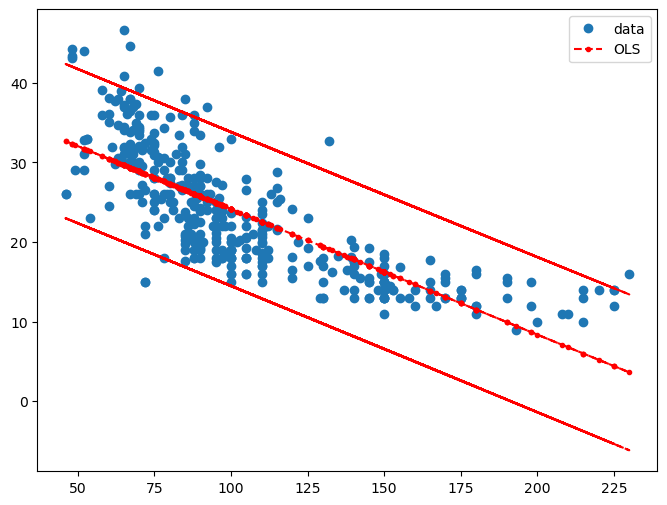

In [18]:
pred_ols = results.get_prediction()
iv_l = pred_ols.summary_frame()["obs_ci_lower"]
iv_u = pred_ols.summary_frame()["obs_ci_upper"]

fig, ax = plt.subplots(figsize=(8, 6))

ax.plot(df[['horsepower']].astype('float'), y, "o", label="data")
ax.plot(df[['horsepower']].astype('float'), results.fittedvalues, "r--.", label="OLS")
ax.plot(df[['horsepower']].astype('float'), iv_u, "r--")
ax.plot(df[['horsepower']].astype('float'), iv_l, "r--")
ax.legend(loc="best")

https://www.youtube.com/watch?v=ApmvZ0KZwI8&list=WL&index=4&ab_channel=CoeusLearning

Text(0.5, 1.0, 'Correlation of error terms')

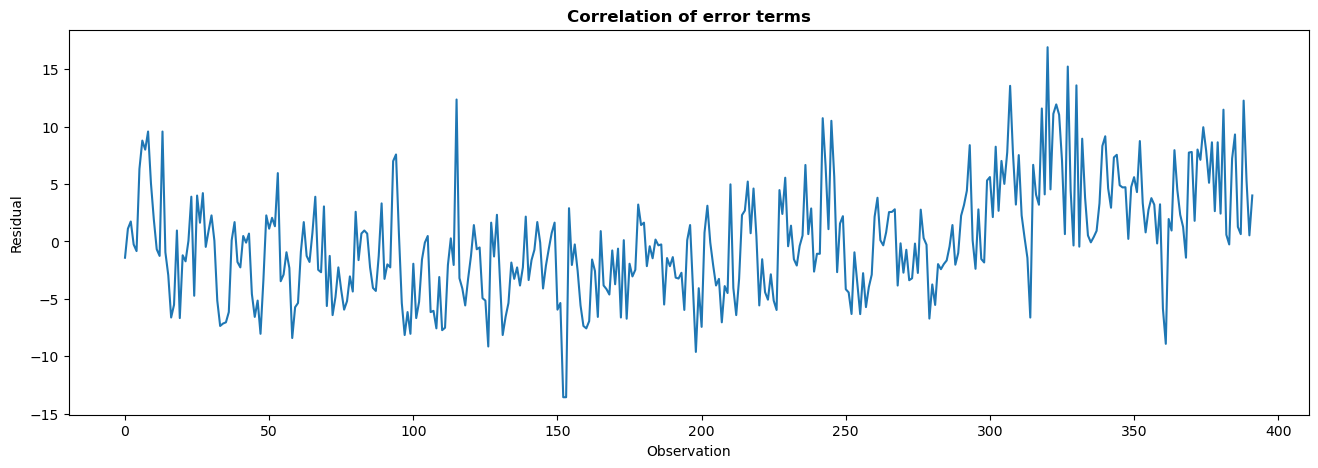

In [20]:
model1_residuals = results.get_influence().resid
plt.figure(1, figsize=(16, 5))
ax = sns.lineplot(x=list(range(model1_residuals.shape[0])), y=model1_residuals)
plt.xlabel('Observation')
plt.ylabel('Residual')
plt.title('Correlation of error terms', fontweight='bold')

Correlation of error terms: The Correlation of Error Terms plot shows errors against ordered observations in our dataset. We see a slight increase in error above the 300th observation suggesting some correlation effect. This could mean that our estimated standard errors underestimate the true standard errors. Our confidence and prediction intervals may be narrower than they should be.

Checking for autocorrelation To ensure the absence of autocorrelation we use Ljungbox test. Null Hypothesis: Autocorrelation is absent.

In [44]:
from statsmodels.stats import diagnostic as diag
diag.acorr_ljungbox(results.resid, lags = 1)

,lb_stat,lb_pvalue
1,114.8722,0.0000


The p-value is <0.05 thus we reject the null hypothesis and can say that there is no evidence that autocorrelation is absent.

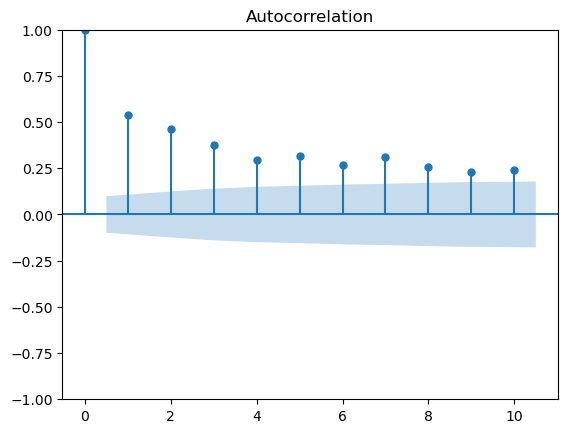

In [48]:
# autocorrelation
sm.graphics.tsa.plot_acf(results.resid, lags=10)
plt.show()

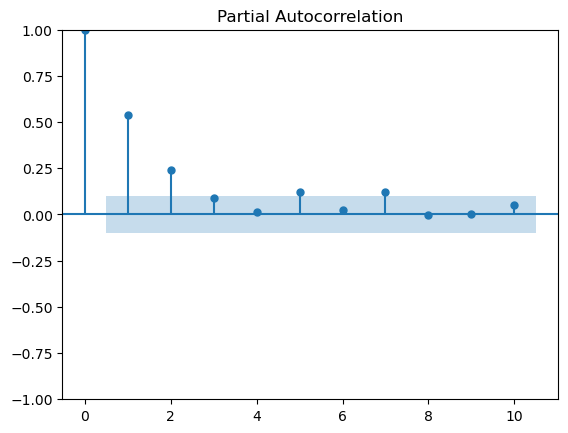

In [49]:
# partial autocorrelation
sm.graphics.tsa.plot_pacf(results.resid, lags=10)
plt.show()

The results show signs of autocorelation since there are spikes outside the blue confidence interval region. This could be a factor of seasonality in the data.

A test of autocorrelation that is designed to take account of the regression model is the Durbin-Watson test (also included in the regression summary). It is used to test the hypothesis that there is no lag one autocorrelation in the residuals. A small p-value indicates there is significant autocorrelation remaining in the residuals. If there is no autocorrelation, the Durbin-Watson distribution is symmetric around 2.

If Durbin–Watson is less than 1.0, there may be cause for concern. Small values of d indicate successive error terms are positively correlated. If d > 2, successive error terms are negatively correlated.

In [50]:
sm.stats.durbin_watson(results.resid)

0.9195392995415309

In [26]:
from statsmodels.compat import lzip
import statsmodels.formula.api as smf
import statsmodels.stats.api as sms

The Jarque–Bera (JB) test is a goodness-of-fit test of whether sample data have the skewness and kurtosis matching a normal distribution. The null hypothesis is a joint hypothesis of:
- the skewness being zero and
- the kurtosis being 3.

Samples from a normal distribution have an:
- expected skewness of 0 and
- an expected excess kurtosis of 0 (which is the same as a kurtosis of 3).

Any deviation from this assumptions increases the JB statistic. Next, we calculate the statistics but you can also find the results of the Jarque-Bera test in the regression summary.

In [27]:
# Normality of the residuals
name = ["Jarque-Bera", "Chi^2 two-tail prob.", "Skew", "Kurtosis"]
test = sms.jarque_bera(results.resid)
lzip(name, test)

[('Jarque-Bera', 17.304523605195012),
 ('Chi^2 two-tail prob.', 0.00017473119341274005),
 ('Skew', 0.4924929406838642),
 ('Kurtosis', 3.2987698820090974)]

The p-value is below 0.05 and we can reject the Null. Therefore, the test gives us an indication that the errors are not normally distributed.

Another test for normal distribution of residuals is the Omnibus normtest (also included in the regression summary). The test allows us to check whether or not the model residuals follow an approximately normal distribution.
Our null hypothesis is that the residuals are from a normal distribution.

In [28]:
# Omni test:
name = ["Chi^2", "Two-tail probability"]
test = sms.omni_normtest(results.resid)
lzip(name, test)

[('Chi^2', 16.432334104701745),
 ('Two-tail probability', 0.0002702489322697853)]

The p-value is below 0.05 and we can reject the Null. Therefore, the test gives us an indication that the errors are not from a normal distribution.

In [22]:
# Multicollinearity (Condition Number)
np.linalg.cond(results.model.exog)

322.36910312992273

The Breusch-Pagan Lagrange Multiplier test can be used to identify heteroscedasticity. The test assumes homoscedasticity (this is the null hypothesis) which means that the residual variance does not depend on the values of the variables in x. Note that this test may exaggerate the significance of results in small or moderately large samples. In this case the F-statistic is preferable. If one of the test statistics is significant (i.e., p <= 0.05), then you have indication of heteroscedasticity.

In [25]:
# Heteroskedasticity tests
# Breush-Pagan test:
name = ["Lagrange multiplier statistic", "p-value", "f-value", "f p-value"]
test = sms.het_breuschpagan(results.resid, results.model.exog)
lzip(name, test)

[('Lagrange multiplier statistic', 8.753469480137877),
 ('p-value', 0.0030901360113709275),
 ('f-value', 8.90772081517081),
 ('f p-value', 0.0030184985629866496)]

In our case, both p-values are below 0.05, which means we can reject the null hypothesis.

In [29]:
# Heteroskedasticity tests
# Goldfeld-Quandt test
# Null Hypothesis: Error terms are homoscedastic
name = ["F statistic", "p-value"]
test = sms.het_goldfeldquandt(results.resid, results.model.exog)
lzip(name, test)

[('F statistic', 1.9347529749880608), ('p-value', 2.6861725775803545e-06)]

Since p value is less than 0.05 in Goldfeld Quandt Test, we can reject the null hypothesis that error terms are homoscedastic. We can not say that the residuals have constant variance.

In [30]:
# Linearity
# Harvey-Collier multiplier test for Null hypothesis that the linear specification is correct:
name = ["t value", "p value"]
test = sms.linear_harvey_collier(results)
lzip(name, test)

[('t value', 6.9275846051892005), ('p value', 1.788353466232718e-11)]

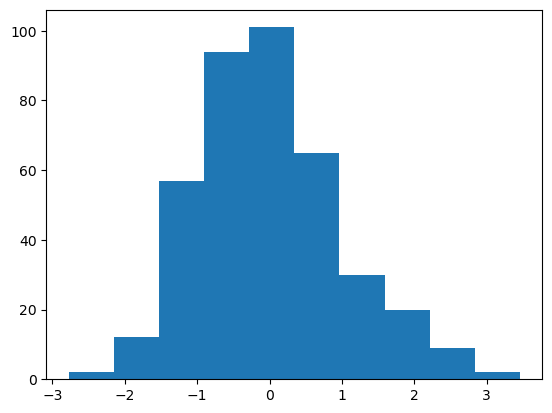

In [31]:
# Normalized residuals
model1_norm_residuals = results.get_influence().resid_studentized_internal
plt.hist(model1_norm_residuals)
plt.show()

If the absolute value of studentized residuals is more than 3 then that observation is considered as an outlier and hence should be treated.

Checking normality of residuals: We can use Shapiro Wilk test from scipy library to check the normality of residuals. Null Hypothesis: The residuals are normally distributed.

In [41]:
from scipy import stats
stats.shapiro(results.get_influence().resid)

ShapiroResult(statistic=0.9820658564567566, pvalue=8.737531607039273e-05)

Since the pvalue is < 0.05 at a 5% level of significance we can say that the residuals are rejected to be normally distributed.

# ISLR Applied EXERCISE 3.9

In [3]:
dir_data = PATH / Path('data')
input_file = 'Auto.csv'
file_path_data = dir_data / Path(input_file)

df = pd.read_csv(file_path_data, na_values = ["?"])
df = df.dropna() # drop all missing values
df = df.drop(columns='name')
df

,mpg,cylinders,displacement,horsepower,weight,acceleration,year,origin
0,18.0,8,307.0,130.0,3504,12.0,70,1
1,15.0,8,350.0,165.0,3693,11.5,70,1
2,18.0,8,318.0,150.0,3436,11.0,70,1
3,16.0,8,304.0,150.0,3433,12.0,70,1
4,17.0,8,302.0,140.0,3449,10.5,70,1
...,...,...,...,...,...,...,...,...
392,27.0,4,140.0,86.0,2790,15.6,82,1
393,44.0,4,97.0,52.0,2130,24.6,82,2
394,32.0,4,135.0,84.0,2295,11.6,82,1
395,28.0,4,120.0,79.0,2625,18.6,82,1


Origin has automatically been label encoded (which is not 100% correct). Cylinders can be interpreted also as an ordinal variable also but has been automatically label encoded in the csv from the authors. 

In [4]:
df.dtypes

mpg             float64
cylinders         int64
displacement    float64
horsepower      float64
weight            int64
acceleration    float64
year              int64
origin            int64
dtype: object

In [5]:
df['origin'] = df['origin'].astype('object') # To remove warnings
df.loc[df.origin == 1, 'origin'] = "American"
df.loc[df.origin == 2, 'origin'] = "European"
df.loc[df.origin == 3, 'origin'] = "Japanese"

In [6]:
df

,mpg,cylinders,displacement,horsepower,weight,acceleration,year,origin
0,18.0,8,307.0,130.0,3504,12.0,70,American
1,15.0,8,350.0,165.0,3693,11.5,70,American
2,18.0,8,318.0,150.0,3436,11.0,70,American
3,16.0,8,304.0,150.0,3433,12.0,70,American
4,17.0,8,302.0,140.0,3449,10.5,70,American
...,...,...,...,...,...,...,...,...
392,27.0,4,140.0,86.0,2790,15.6,82,American
393,44.0,4,97.0,52.0,2130,24.6,82,European
394,32.0,4,135.0,84.0,2295,11.6,82,American
395,28.0,4,120.0,79.0,2625,18.6,82,American


In [7]:
df = pd.get_dummies(df, drop_first=True)
df = sm.add_constant(df)
df

,const,mpg,cylinders,displacement,horsepower,weight,acceleration,year,origin_European,origin_Japanese
0,1.0,18.0,8,307.0,130.0,3504,12.0,70,False,False
1,1.0,15.0,8,350.0,165.0,3693,11.5,70,False,False
2,1.0,18.0,8,318.0,150.0,3436,11.0,70,False,False
3,1.0,16.0,8,304.0,150.0,3433,12.0,70,False,False
4,1.0,17.0,8,302.0,140.0,3449,10.5,70,False,False
...,...,...,...,...,...,...,...,...,...,...
392,1.0,27.0,4,140.0,86.0,2790,15.6,82,False,False
393,1.0,44.0,4,97.0,52.0,2130,24.6,82,True,False
394,1.0,32.0,4,135.0,84.0,2295,11.6,82,False,False
395,1.0,28.0,4,120.0,79.0,2625,18.6,82,False,False


In [8]:
df = df.astype(float)
df

,const,mpg,cylinders,displacement,horsepower,weight,acceleration,year,origin_European,origin_Japanese
0,1.0,18.0,8.0,307.0,130.0,3504.0,12.0,70.0,0.0,0.0
1,1.0,15.0,8.0,350.0,165.0,3693.0,11.5,70.0,0.0,0.0
2,1.0,18.0,8.0,318.0,150.0,3436.0,11.0,70.0,0.0,0.0
3,1.0,16.0,8.0,304.0,150.0,3433.0,12.0,70.0,0.0,0.0
4,1.0,17.0,8.0,302.0,140.0,3449.0,10.5,70.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
392,1.0,27.0,4.0,140.0,86.0,2790.0,15.6,82.0,0.0,0.0
393,1.0,44.0,4.0,97.0,52.0,2130.0,24.6,82.0,1.0,0.0
394,1.0,32.0,4.0,135.0,84.0,2295.0,11.6,82.0,0.0,0.0
395,1.0,28.0,4.0,120.0,79.0,2625.0,18.6,82.0,0.0,0.0


In [9]:
df.corr()

,const,mpg,cylinders,displacement,horsepower,weight,acceleration,year,origin_European,origin_Japanese
const,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mpg,NaN,1.000000,-0.777618,-0.805127,-0.778427,-0.832244,0.423329,0.580541,0.244313,0.451454
cylinders,NaN,-0.777618,1.000000,0.950823,0.842983,0.897527,-0.504683,-0.345647,-0.352324,-0.404209
displacement,NaN,-0.805127,0.950823,1.000000,0.897257,0.932994,-0.543800,-0.369855,-0.371633,-0.440825
horsepower,NaN,-0.778427,0.842983,0.897257,1.000000,0.864538,-0.689196,-0.416361,-0.284948,-0.321936
weight,NaN,-0.832244,0.897527,0.932994,0.864538,1.000000,-0.416839,-0.309120,-0.293841,-0.447929
acceleration,NaN,0.423329,-0.504683,-0.543800,-0.689196,-0.416839,1.000000,0.290316,0.208298,0.115020
year,NaN,0.580541,-0.345647,-0.369855,-0.416361,-0.309120,0.290316,1.000000,-0.037745,0.199841
origin_European,NaN,0.244313,-0.352324,-0.371633,-0.284948,-0.293841,0.208298,-0.037745,1.000000,-0.230157
origin_Japanese,NaN,0.451454,-0.404209,-0.440825,-0.321936,-0.447929,0.115020,0.199841,-0.230157,1.000000


In [10]:
X = df.drop(columns=['mpg'])
y = df['mpg']
model = sm.OLS(y, X)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    mpg   R-squared:                       0.824
Model:                            OLS   Adj. R-squared:                  0.821
Method:                 Least Squares   F-statistic:                     224.5
Date:                Mon, 20 May 2024   Prob (F-statistic):          1.79e-139
Time:                        10:43:15   Log-Likelihood:                -1020.5
No. Observations:                 392   AIC:                             2059.
Df Residuals:                     383   BIC:                             2095.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const             -17.9546      4.677     -3.839      0.000     -27.150      -8.759
cylinders          -0.4897      0.321     -1.524      0.128      -1.121       0.142
displacement        0.0240      0.008      3.133      0.002       0.009       0.039
horsepower         -0.0182      0.014     -1.326      0.185      -0.045       0.009
weight             -0.0067      0.001    -10.243      0.000      -0.008      -0.005
acceleration        0.0791      0.098      0.805      0.421      -0.114       0.272
year                0.7770      0.052     15.005      0.000       0.675       0.879
origin_European     2.6300      0.566      4.643      0.000       1.516       3.744
origin_Japanese     2.8532      0.553      5.162      0.000       1.766       3.940
==============================================================================
Omnibus:                       23.395   Durbin-Watson:                   1.291
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               34.452
Skew:                           0.444   Prob(JB):                     3.30e-08
Kurtosis:                       4.150   Cond. No.                     8.70e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 8.7e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [11]:
# Residual Standard Error (RMSE)
np.sqrt(results.mse_resid)

3.306529531198317

Since the F-statistic is 224.5, giving a p-value of essentially zero for the null hypothesis  H0:βj=0 for all j, there is strong evidence to believe that there is a relationship between the predictors and the response. The predictors that appear to have a statistically significant relationship to the response mpg are displacement, weight, year, originEuropean, and originJapanese.

The coefficient of 0.777 for the year variable suggests that when we fix the number of engine cylinders, engine displacement, horsepower, weight, acceleration, and country of origin, fuel efficiency increases on average by about 0.777 miles per gallon each year. In other words, the model suggests that we would expect cars from 1971 to be more fuel efficient by 0.777 miles per gallon on average compared to equivalent cars from 1970. 

The coefficients for originEuropean and originJapanese suggest that compared to equivalent cars from the United States, we would expect European cars to be more fuel efficient by 2.630 miles per gallon on average, and Japanese cars to be more fuel efficient by 2.853 miles per gallon on average.

In [12]:
vals = [VIF(X, i) for i in range(1, X.shape[1])]
vif = pd.DataFrame({'vif':vals}, index=X.columns[1:])
vif

,vif
cylinders,10.737771
displacement,22.937950
horsepower,9.957265
weight,11.074349
acceleration,2.625906
year,1.301373
origin_European,1.649271
origin_Japanese,1.762692


As we can see, cylinders, horsepower, and weight each have variance inflation factors of approximately 10, while displacement has a variance inflation factor of almost 20. This, combined with the large in absolute value correlation values between those variables, provides strong evidence that there is a fair amount of multicollinearity between those four predictors. This makes sense when considering that the number of cylinders, engine displacement, and horsepower are closely related as characteristics of the car's engine, which also contributes a fair proportion of a car's weight.

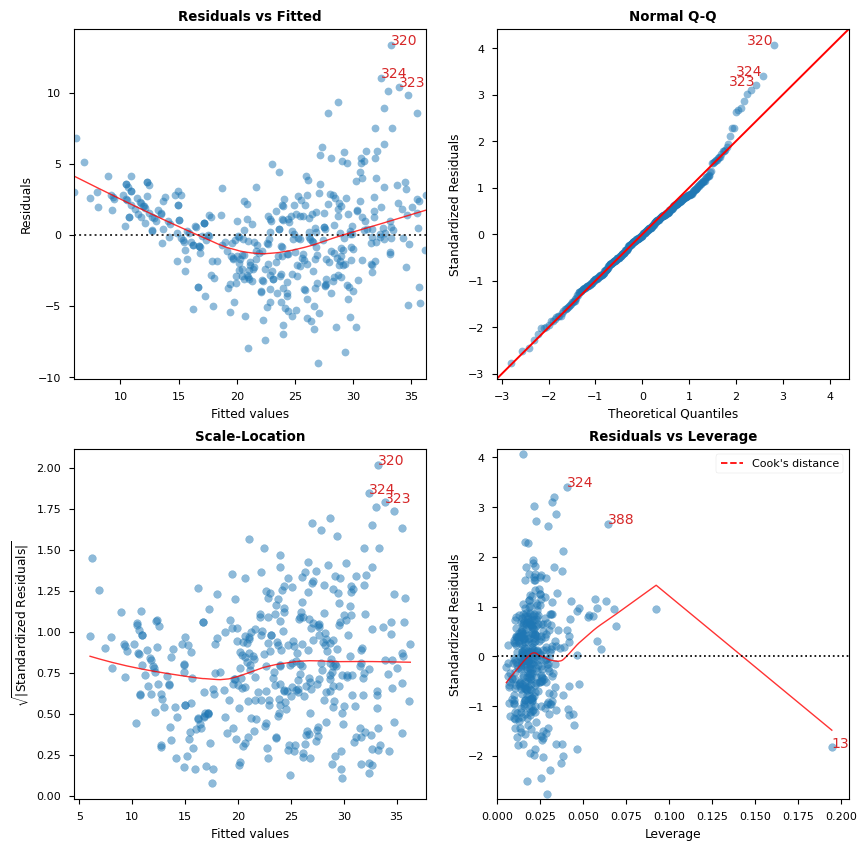

,Features,VIF Factor
6,year,1.30
7,origin_European,1.65
8,origin_Japanese,1.76
5,acceleration,2.63
3,horsepower,9.96
1,cylinders,10.74
4,weight,11.07
2,displacement,22.94
0,const,784.27


In [13]:
cls = LinearRegDiagnostic(results)
vif, fig, ax = cls()
vif

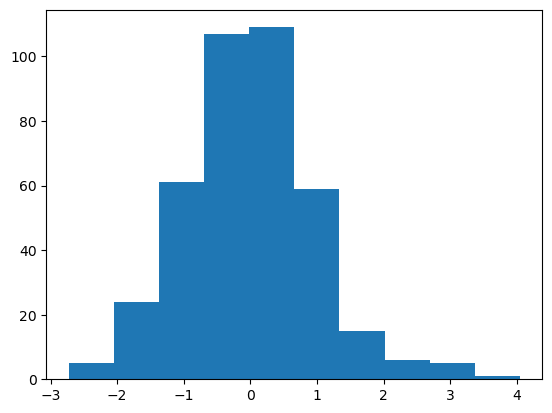

In [14]:
plt.hist(results.resid_pearson)
plt.show()

In [8]:
def lm_stats(X, y, y_pred):
    """ LEVERAGE & STUDENTISED RESIDUALS
    - https://en.wikipedia.org/wiki/Studentized_residual#How_to_studentize
    """
    # Responses as np array vector
    try: 
        y.shape[1] == 1
        # take first dimension as vector
        y = y.iloc[:,0]
    except:
        pass
    y = np.array(y)
    
    # Residuals
    residuals = np.array(y - y_pred)
    
    # Hat matrix
    H = np.array(X @ np.linalg.inv(X.T @ X)) @ X.T
    
    # Leverage
    h_ii = np.diagonal(H)
    
    ## Externally studentised residual
    # In this case external studentisation is most appropriate 
    # because we are looking for outliers.
    
    # Estimate variance (externalised)
    σi_est = []
    for i in range(X.shape[0]):
        # exclude ith observation from estimation of variance
        external_residuals = np.delete(residuals, i)
        σi_est += [np.sqrt((1 / (X.shape[0] - X.shape[1] - 1)) * np.sum(np.square(external_residuals)))]
    σi_est = np.array(σi_est)
    
    # Externally studentised residuals
    t = residuals / σi_est * np.sqrt(1 - h_ii)
    

    # Return dataframe
    return pd.DataFrame({'residual': residuals,
                         'leverage': h_ii, 
                         'studentised_residual': t,
                         'y_pred': y_pred})


def lm_plot(lm_stats_df): 
    """Provides R style residual plots based on results from lm_stat()"""
    # Parse stats
    t      = lm_stats_df['studentised_residual']
    h_ii   = lm_stats_df['leverage']
    y_pred = lm_stats_df['y_pred']
    
    # setup axis for grid
    plt.figure(1, figsize=(16, 18))
    
    # Studentised residual plot
    plt.subplot(321)
    ax = sns.regplot(x=y_pred, y=t, lowess=True)
    plt.xlabel('Fitted values')
    plt.ylabel('Studentised residuals')
    plt.title('Externally studentised residual plot', fontweight='bold')
    # Draw Hastie and Tibshirani's bounds for possible outliers
    ax.axhline(y=3, color='r', linestyle='dashed')
    ax.axhline(y=-3, color='r', linestyle='dashed');
    
    # Normal Q-Q plot
    plt.subplot(322)
    ax = stats.probplot(t, dist='norm', plot=plt)
    plt.ylabel('Studentised residuals')
    plt.title('Normal Q-Q', fontweight='bold')
    
    # Standardised residuals
    plt.subplot(323)
    ax = sns.regplot(x=y_pred, y=np.sqrt(np.abs(t)), lowess=True)
    plt.xlabel('Fitted values')
    plt.ylabel('√Standardized residuals')
    plt.title('Scale-Location', fontweight='bold')
    
    # Residuals vs Leverage plot
    plt.subplot(324)
    ax = sns.scatterplot(x=h_ii, y=t)
    plt.xlabel('Leverage')
    plt.ylabel('Studentised residuals')
    plt.title('Externally studentised residual vs Leverage', fontweight='bold')

    plt.show()

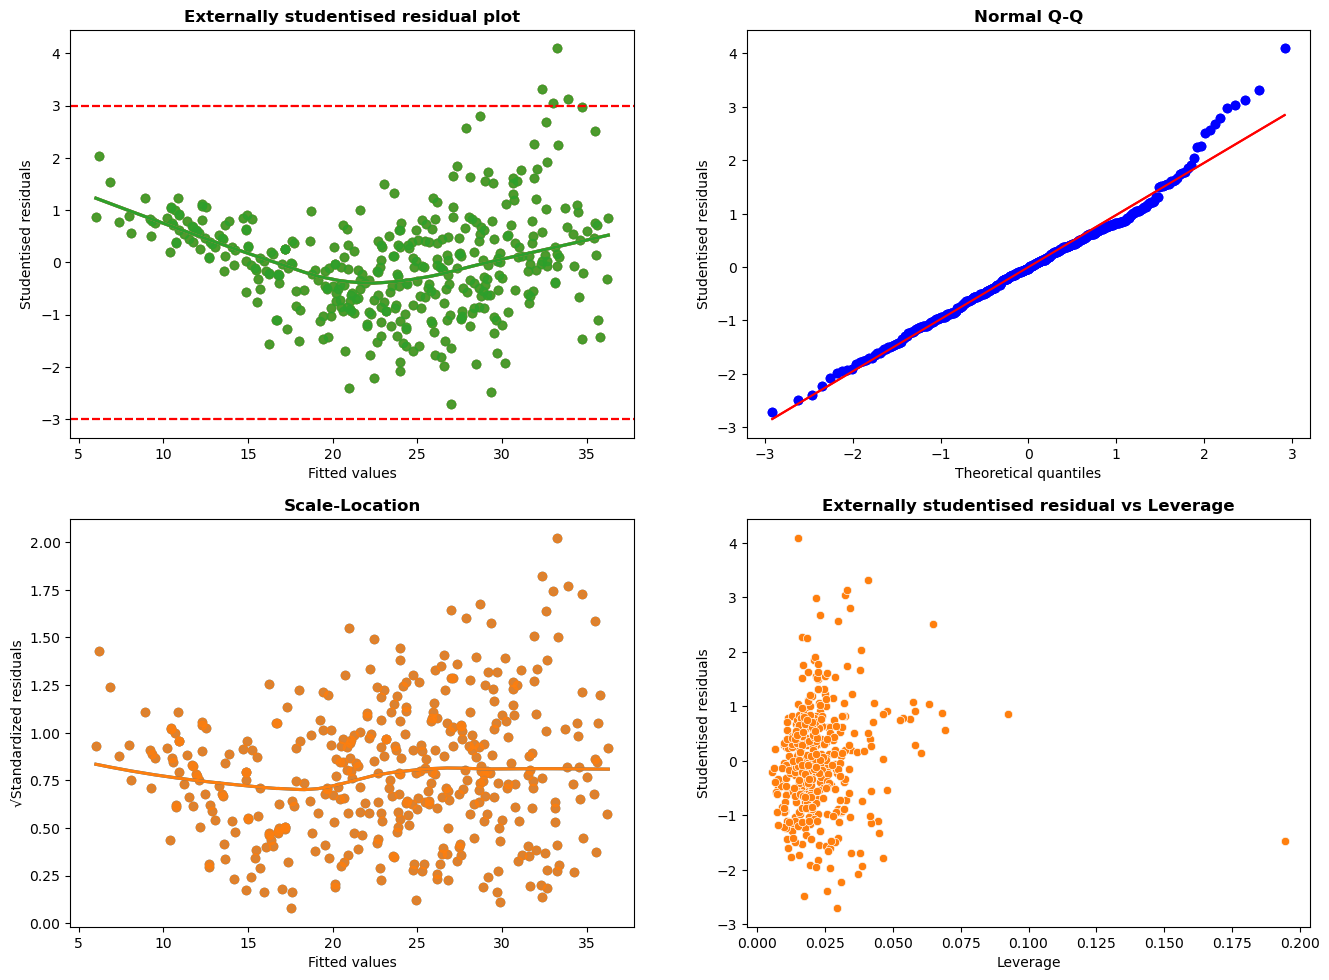

In [24]:
# Make predictions
y_pred = np.array(results.predict(X))

# Analyse residuals
lm_plot(lm_stats(X, y, y_pred))

Looking at the Residuals vs. Fitted plot, there appears to be moderate U-shape, which indicates that there might be non-linearity in the data. 

First, there are a number of observations with standardized residual values with absolute value greater than or equal to 3. Those are likely outliers. This is confirmed by looking at the Scale-Location plot.

Going back the the Residuals vs. Leverage plot, we also see that there are a couple points with unusually high leverage. 

Heteroscedasticity: A conical pattern is apparent in the top-left plot suggesting that variance of residuals increases with response. The bottom left plot suggests that a square-root transform helps to mitigate this effect.

Outliers: The top-left plot suggests that there are five potential outliers towards the high end of our predicted responses. The bottom-right plot suggests that these outliers have low leverage, and so probably don't have a overly dispraportionate effect on our model.

Leverage: The bottom right plot reveals one point with particularly high leverage, although with a value around -1.2 this point isn't an outlier in terms of studentised residuals.

Normality: The top-right plot shows a normal distribution except for high value residuals. This suggests that the model under-estimates mpg for a larger number of observations than we might expect assuming a normal distribution.

# ISLR Applied EXERCISE 3.10

In [3]:
dir_data = PATH / Path('data')
input_file = 'Carseats.csv'
file_path_data = dir_data / Path(input_file)

df = pd.read_csv(file_path_data)
df = df.dropna() # drop all missing values
df

,Sales,CompPrice,Income,Advertising,Population,Price,ShelveLoc,Age,Education,Urban,US
0,9.50,138,73,11,276,120,Bad,42,17,Yes,Yes
1,11.22,111,48,16,260,83,Good,65,10,Yes,Yes
2,10.06,113,35,10,269,80,Medium,59,12,Yes,Yes
3,7.40,117,100,4,466,97,Medium,55,14,Yes,Yes
4,4.15,141,64,3,340,128,Bad,38,13,Yes,No
...,...,...,...,...,...,...,...,...,...,...,...
395,12.57,138,108,17,203,128,Good,33,14,Yes,Yes
396,6.14,139,23,3,37,120,Medium,55,11,No,Yes
397,7.41,162,26,12,368,159,Medium,40,18,Yes,Yes
398,5.94,100,79,7,284,95,Bad,50,12,Yes,Yes


In [4]:
columns = ['Sales', 'Price', 'US']
df = df[columns]
df

,Sales,Price,US
0,9.50,120,Yes
1,11.22,83,Yes
2,10.06,80,Yes
3,7.40,97,Yes
4,4.15,128,No
...,...,...,...
395,12.57,128,Yes
396,6.14,120,Yes
397,7.41,159,Yes
398,5.94,95,Yes


In [5]:
# Extract categorical columns from the dataframe, here we extract the columns with object datatype as they are the categorical columns
categorical_columns = df.select_dtypes(include=['object']).columns.tolist()

# Initialize OneHotEncoder, drop first reduces collinearity 
encoder = OneHotEncoder(drop='first')

# Apply one-hot encoding to the categorical columns (fit_transform)
one_hot_encoded = encoder.fit_transform(df[categorical_columns]).toarray()

# Create a DataFrame with the one-hot encoded columns, we use get_feature_names_out() to get the column names for the encoded data
one_hot_df = pd.DataFrame(one_hot_encoded, columns=encoder.get_feature_names_out(categorical_columns))

# Concatenate the one-hot encoded dataframe with the original dataframe, axis=1 is concatenating on the column
df_encoded = pd.concat([df, one_hot_df], axis=1)

# Drop the original categorical columns
df_encoded = df_encoded.drop(categorical_columns, axis=1)
df_encoded

,Sales,Price,US_Yes
0,9.50,120,1.0
1,11.22,83,1.0
2,10.06,80,1.0
3,7.40,97,1.0
4,4.15,128,0.0
...,...,...,...
395,12.57,128,1.0
396,6.14,120,1.0
397,7.41,159,1.0
398,5.94,95,1.0


In [6]:
df_encoded = sm.add_constant(df_encoded)
X = df_encoded.drop(columns='Sales')
y = df_encoded['Sales']
model = sm.OLS(y, X)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Sales   R-squared:                       0.239
Model:                            OLS   Adj. R-squared:                  0.235
Method:                 Least Squares   F-statistic:                     62.43
Date:                Mon, 20 May 2024   Prob (F-statistic):           2.66e-24
Time:                        13:42:06   Log-Likelihood:                -927.66
No. Observations:                 400   AIC:                             1861.
Df Residuals:                     397   BIC:                             1873.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         13.0308      0.631     20.652      0.000      11.790      14.271
Price         -0.0545      0.005    -10.416      0.000      -0.065      -0.044
US_Yes         1.1996      0.258      4.641      0.000       0.692       1.708
==============================================================================
Omnibus:                        0.666   Durbin-Watson:                   1.912
Prob(Omnibus):                  0.717   Jarque-Bera (JB):                0.749
Skew:                           0.092   Prob(JB):                        0.688
Kurtosis:                       2.895   Cond. No.                         607.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

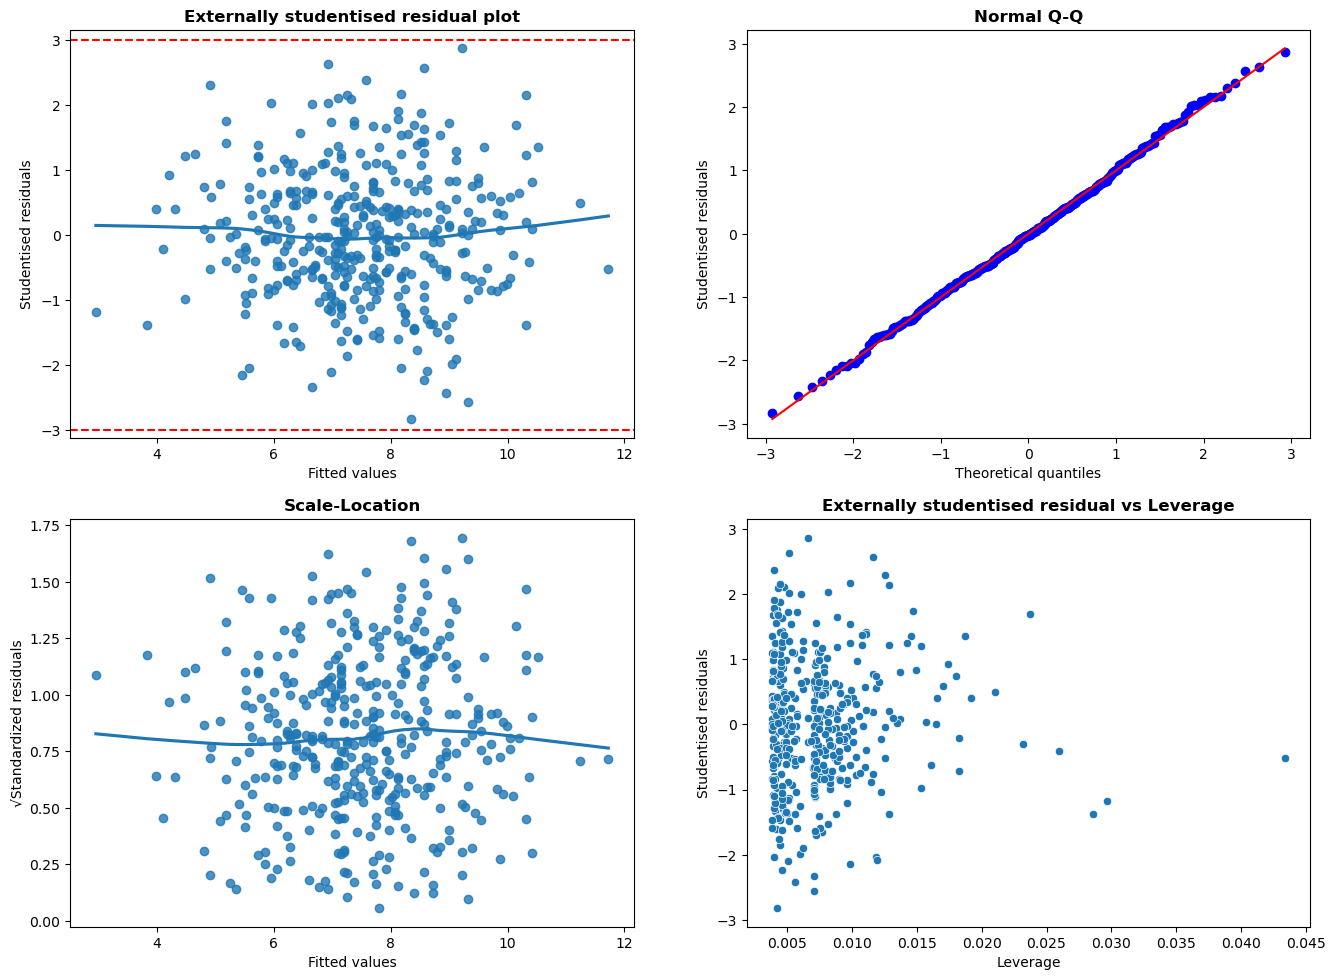

In [9]:
y_pred = np.array(results.predict(X))
lm_plot(lm_stats(X, y, y_pred))

The diagnostic plots above illustrate the fit of our model. The top-left plot shows only subtle discernible pattern suggesting our linear model has achieved a reasonable fit to the data. The distribution of residuals appears normal and there is no heteroscedasticity. There is one observation that stands out as particularly high leverage in the bottom-right plot above, but this observation is not necessarily an outlier.

In [10]:
conf_inter_95 = results.conf_int(alpha=0.05)
conf_inter_95.rename(index=str, columns={0: "min.", 1: "max.",})

,min.,max.
const,11.79032,14.271265
Price,-0.06476,-0.044195
US_Yes,0.69152,1.707766


Calculating the leverage of every case, using the rule hii≥2(p+1)/n to decide which cases are high leverage points:

In [11]:
infl = results.get_influence()
leverage = infl.hat_matrix_diag
print(X.index[leverage > 2 * leverage.mean()].values)

[ 42 125 155 156 159 165 171 174 191 203 208 269 272 313 315 356 365 367
 383 386]


Calculating the Cook's distance of every case, using the rule Di>1 to decide which cases are influential points.

In [12]:
print(X.index[infl.cooks_distance[0] > 1]) # Result shows that no observations are influential points

Index([], dtype='int64')


In [13]:
from statsmodels.compat import lzip
name = ['Lagrange multiplier statistic', 'p-value', 'f-value', 'f p-value']
test = sm.stats.het_breuschpagan(results.resid, results.model.exog)
lzip(name, test)

[('Lagrange multiplier statistic', 4.931431519576579),
 ('p-value', 0.08494801823101464),
 ('f-value', 2.477770277704221),
 ('f p-value', 0.08522730398315373)]

In our case, both p-values are above 0.05, which means we can accept the null hypothesis. Therefore, we have an indication of homoscedasticity.

In [14]:
name = ['Jarque-Bera', 'Chi^2 two-tail prob.', 'Skew', 'Kurtosis']
test = sm.stats.jarque_bera(results.resid)

lzip(name, test)

[('Jarque-Bera', 0.7491126926732533),
 ('Chi^2 two-tail prob.', 0.6875942648463929),
 ('Skew', 0.09214118968493115),
 ('Kurtosis', 2.895182223768211)]

The p-value is above 0.05 and we can not reject H0. Therefore, the test gives us an indication that the errors are normally distributed.

In [15]:
name = ['Chi^2', 'Two-tail probability']
test = sm.stats.omni_normtest(results.resid)
lzip(name, test)

[('Chi^2', 0.6655376257029337), ('Two-tail probability', 0.7169359213693022)]

The p-value is above 0.05 and we can not reject H0. Therefore, the test gives us an indication that the errors are from a normal distribution.

In [16]:
sm.stats.durbin_watson(results.resid)

1.9115915729575963

If there is no autocorrelation, the Durbin-Watson distribution is symmetric around 2.

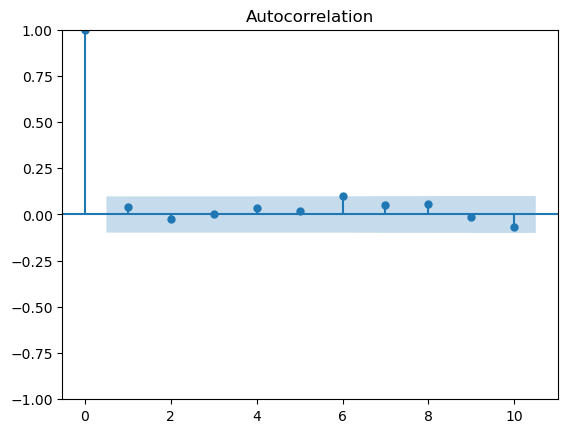

In [17]:
# autocorrelation
sm.graphics.tsa.plot_acf(results.resid, lags=10)
plt.show()

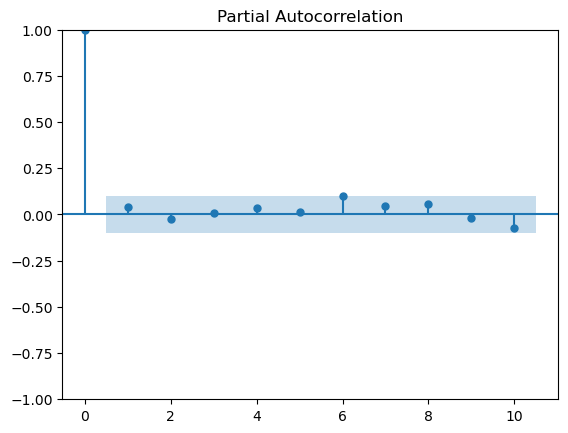

In [18]:
# partial autocorrelation
sm.graphics.tsa.plot_pacf(results.resid, lags=10)
plt.show()

In [23]:
from scipy.stats import spearmanr
# Rank-correlation
spearmanr(y, y_pred)[0]

0.46255913974275625